In [2]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

directory_path = './dags'
directory_plots = './plots'

# Count all the nodes

In [ ]:
def get_all_nodes(dot_file):
    G = nx.nx_agraph.read_dot(dot_file)
    all_nodes = G.nodes()
    
    return all_nodes

# Count all processes

We count all the process node here, short explanation:
exploration shows, that the processes have no shape in the dot-file, we count the amount of processes in a workflow, in the dot-file they have. Examples:

process node: v271 [label="NFCORE_AMPLISEQ:AMPLISEQ:QIIME2_BARPLOT"];

channel operator node: v173 [shape=circle,label="",fixedsize=true,width=0.1,xlabel="collect"];

channel node: v330 [shape=point];

In [ ]:
def get_processes(dot_file):
    G = nx.nx_agraph.read_dot(dot_file)
    
    # identify nodes without 'shape' attribute, assuming they represent processes
    processes = [node for node in G.nodes() if 'shape' not in G.nodes[node]]
    
    return processes

# Count all channels with operators

In [ ]:
def get_channel_operators(dot_file):
    G = nx.nx_agraph.read_dot(dot_file)
    
    # count nodes with 'shape' == 'circle' attribute as channel operator
    count_operators = [node for node, attrs in G.nodes(data=True) if 'shape' in attrs and attrs['shape'] == 'circle']

    return count_operators

In [ ]:
def get_channels(dot_file):
    G = nx.nx_agraph.read_dot(dot_file)
    
    # count nodes with 'shape' == 'point' attribute as channel
    count_operators = [node for node, attrs in G.nodes(data=True) if 'shape' in attrs and attrs['shape'] == 'point']

    return count_operators

In [ ]:
data = []

for filename in os.listdir(directory_path):
    if filename.endswith(".dot"):
        dot_file_path = os.path.join(directory_path, filename)
        pipeline_name = filename.split('_')[0]
        
        operator_count = len(get_channel_operators(dot_file_path))
        process_count = len(get_processes(dot_file_path))
        channel_count = len(get_channels(dot_file_path))
        node_count = len(get_all_nodes(dot_file_path))

        data.append([pipeline_name, operator_count, process_count, channel_count, node_count])

        print(f'Pipeline: {pipeline_name}, Number of operator nodes: {operator_count}')
        print(f'Pipeline: {pipeline_name}, Number of process nodes: {process_count}')
        print(f'Pipeline: {pipeline_name}, Number of channel nodes: {channel_count}')
        print(f'Pipeline: {pipeline_name}, Number of all nodes: {node_count}')
        print('-------------------------------------------------')

In [ ]:
csv_nodes_path = './results/nodes_in_pipelines.csv'
header = ['pipeline', 'operators', 'processes', 'channels', 'total_nodes']

with open(csv_nodes_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(header)
    writer.writerows(data)

print(f'Data has been written to {csv_nodes_path}')

We read the csv-file next and derive our averages there

In [ ]:
csv_nodes_path = './results/nodes_in_pipelines.csv'
df = pd.read_csv(csv_nodes_path)

sum_processes = df['operators'].sum()

print(df.describe())
print(f'Sum of processes in DAGs {sum_processes}')

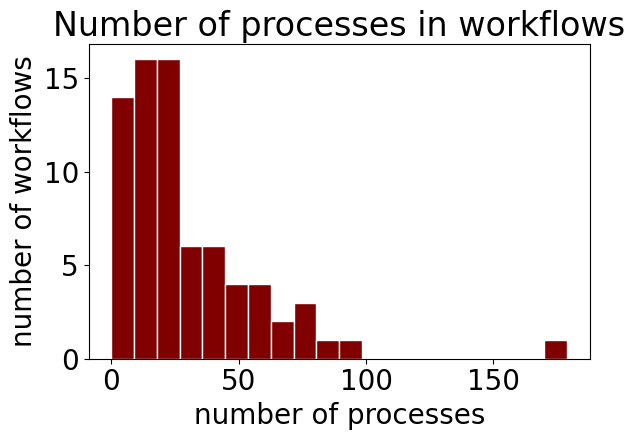

In [2]:
import csv
import matplotlib.pyplot as plt

counts = []
with open('./results/nodes_in_pipelines.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        try:
            count = int(row[2])  # csv-file: pipeline, operators, processes, channels, total_nodes
            counts.append(count)
        except ValueError:
            print(f"Skipping row with non-numeric value in the specified column: {row}")

plt.rc('font', size=20)
plt.hist(counts, bins=20,color='maroon', edgecolor='white')
plt.title('Number of processes in workflows')
plt.xlabel('number of processes')
plt.ylabel('number of workflows')
plt.tight_layout()
plt.savefig(f'{directory_plots}/number_of_processes.png', format="png", bbox_inches='tight')
plt.show()

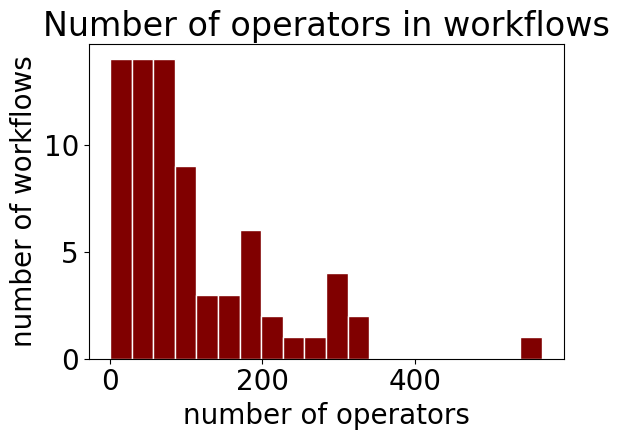

In [3]:
counts = []
with open('./results/nodes_in_pipelines.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        try:
            count = int(row[1])  # csv-file: pipeline, operators, processes, channels, total_nodes
            counts.append(count)
        except ValueError:
            print(f"Skipping row with non-numeric value in the specified column: {row}")

plt.rc('font', size=20)
plt.hist(counts, bins=20,color='maroon', edgecolor='white')
plt.title('Number of operators in workflows')
plt.xlabel('number of operators')
plt.ylabel('number of workflows')
plt.tight_layout()
plt.savefig(f'{directory_plots}/number_of_operators.png', format="png", bbox_inches='tight')
plt.show()

# Longest path in a workflow (with all nodes and processes)

In [ ]:
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv

directory_path = './dags'
directory_plots = './plots'

We are looking for the longest path, considering all nodes here

In [ ]:
def find_longest_path(dot_file):
    G = nx.nx_agraph.read_dot(dot_file)

    longest_path_nodes = nx.dag_longest_path(G)

    return longest_path_nodes

Here you can change the label, to get all nodes or just the processes

In [ ]:
import os
import csv
import networkx as nx

def longest_path_processes(dot_file):
    g = nx.nx_agraph.read_dot(dot_file)
    
    # we want to delete the operator and channel nodes, but keep the edges 
    nodes_to_delete = [node for node, attr in g.nodes(data=True) if 'shape' in attr]

    node_labels = {}

    for node, attr in g.nodes(data=True):
        node_labels[node] = attr.get('label', '')  # get the label of the node, otherwise empty string

    for node in nodes_to_delete:
        # connect in and out nodes with parent and child
        for in_src, _ in g.in_edges(node):
            for _, out_dst in g.out_edges(node):
                g.add_edge(in_src, out_dst)

        g.remove_node(node)
        
    # find longest path in modified graph
    longest_path = nx.dag_longest_path(g)
    
    longest_path_labels = [node_labels[node] for node in longest_path]
    
    return len(longest_path), longest_path_labels

def longest_path_to_csv(directory):
    csv_data = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.dot'):
            dot_file = os.path.join(directory, filename)
            pipeline = filename.split('.')[0]
            length, longest_path_labels = longest_path_processes(dot_file)
            # to not consider empty pipelines
            if len(longest_path_labels) != 0:
                length = len(longest_path_labels) -1
            csv_data.append((pipeline, length, longest_path_labels))
    
    with open('./results/longest_paths_label.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['pipeline', "longest_path_length", "longest_path_label"])
        writer.writerows(csv_data)

directory_path = "./dags"
longest_path_to_csv(directory_path)

In [ ]:
import pandas as pd

pd.set_option('display.max_colwidth', None)
df_longest_paths = pd.read_csv('./results/longest_paths_label.csv')
df_longest_paths

In [ ]:
df_longest_paths.describe()

We plot out results for the processes next

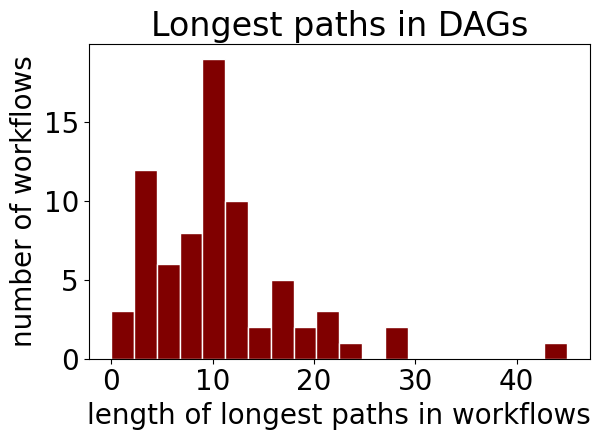

In [4]:
import csv
import matplotlib.pyplot as plt
directory_plots = 'plots'

df_longest_paths = pd.read_csv('./results/longest_paths_label.csv')

longest_path_lengths = df_longest_paths['longest_path_length']

plt.rc('font', size=20)
plt.hist(longest_path_lengths, bins=20, color='maroon', edgecolor='white')
plt.title('Longest paths in DAGs')
plt.xlabel('length of longest paths in workflows')
plt.ylabel('number of workflows')
plt.tight_layout()

plt.savefig(f'{directory_plots}/longest_path.png', format="png", bbox_inches='tight')
plt.show()

# Find shortest path

Taking the first node as source and last node as target of longest path, calculate the shortest path between the source and target. As some dot-files have no process inside, e.g. gwas.dot exception handling is required

2nd solution idea: calculate shortest path, considering all nodes with no out-degree

In [ ]:
import os
import csv
import networkx as nx

def shortest_path_processes(dot_file):
    
    # first code is similar to calculating the longest path, so we have just the DAG with out processes
    G = nx.nx_agraph.read_dot(dot_file)
    
    # we want to delete the operator and channel nodes, but keep the edges 
    nodes_to_delete = [node for node, attr in G.nodes(data=True) if 'shape' in attr]

    node_labels = {}

    for node, attr in G.nodes(data=True):
        node_labels[node] = attr.get('label', '')  # get the label of the node, otherwise empty string

    for node in nodes_to_delete:
        # connect in and out nodes with parent and child
        for in_src, _ in G.in_edges(node):
            for _, out_dst in G.out_edges(node):
                G.add_edge(in_src, out_dst)

        G.remove_node(node)
    
    if len(G.nodes()) == 0:
        return []
    
    longest_path = nx.dag_longest_path(G)
    
    # if longest path empty, return empty list
    if len(longest_path) == 0:
        return []
    
    source_node = longest_path[0]
    
    # get all nodes with no outgoing edges
    target_nodes = [node for node in G.nodes() if G.out_degree(node) == 0]

    shortest_shortest_path_length = float('inf')
    shortest_shortest_path = None

    # calculate shortest path for each target_node and take the shortest one
    for target_node in target_nodes:
        try:
            shortest_path = nx.shortest_path(G, source=source_node, target=target_node)
            shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node)
            if shortest_path_length < shortest_shortest_path_length:
                shortest_shortest_path_length = shortest_path_length
                shortest_shortest_path = shortest_path
        except nx.NetworkXNoPath:
            pass
        
    shortest_path_labels = [node_labels[node] for node in shortest_shortest_path]
    
    return shortest_path_labels

def shortest_path_to_csv(directory):
    csv_data = []
    
    for filename in os.listdir(directory):
        if filename.endswith('.dot'):
            dot_file = os.path.join(directory, filename)
            pipeline = filename.split('.')[0]
            shortest_path_labels = shortest_path_processes(dot_file)
            
            if len(shortest_path_labels) != 0:
                length = len(shortest_path_labels) -1
            csv_data.append((pipeline, length, shortest_path_labels))
            
    with open('./results/shortest_path_label.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['pipeline', "shortest_path_length", "shortest_path_label"])
        writer.writerows(csv_data)

In [ ]:
directory_path = './dags'
shortest_path_to_csv(directory_path)

In [ ]:
import pandas as pd

df_shortest_paths = pd.read_csv('./results/shortest_path_label.csv')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

df_shortest_paths

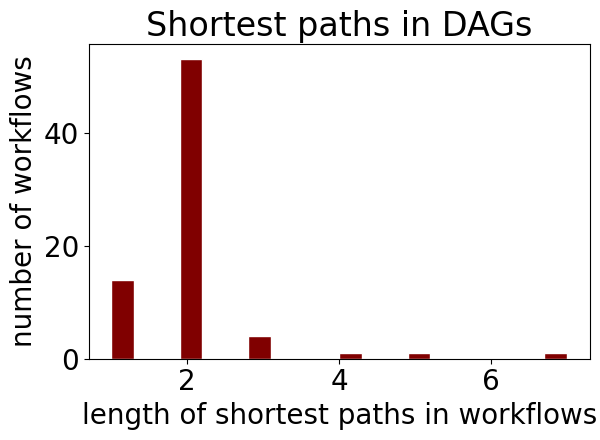

In [5]:
import csv
import matplotlib.pyplot as plt

directory_plots = './plots'

df_longest_paths = pd.read_csv('./results/shortest_path_label.csv')

shortest_path_lengths = df_longest_paths['shortest_path_length']

plt.rc('font', size=20)
plt.hist(shortest_path_lengths, bins=20, color='maroon', edgecolor='white')
plt.title('Shortest paths in DAGs')
plt.xlabel('length of shortest paths in workflows')
plt.ylabel('number of workflows')
plt.tight_layout()

plt.savefig(f'{directory_plots}/shortest_path.png', format="png", bbox_inches='tight')
plt.show()

# Measure the in- and out- degree of process nodes

In [ ]:
import networkx as nx
import os
import csv
import pandas as pd

directory_path = './dags'

In [ ]:
def get_processes_degree(dot_file):
    G = nx.nx_agraph.read_dot(dot_file)
    
    processes = [node for node in G.nodes() if 'shape' not in G.nodes[node]]
    
    process_data = []
    for node in processes:
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)
        
        # e.g.: if its 2 in and 0 out -> we take the 2
        ratio = in_degree / out_degree if out_degree != 0 else in_degree
        
        process_data.append((node, in_degree, out_degree, ratio))
    
    return process_data

The average in and out degree ratio 

In [ ]:
def average_ratio_over_all_nodes(dot_file):
    
    process_data = get_processes_degree(dot_file)
    total_ratio = sum(data[3] for data in process_data)
    
    if process_data:
        average_ratio = total_ratio / len(process_data)
    else:
        average_ratio = 0
    
    return average_ratio

In [ ]:
output_file = './results/in_out_degree_ratio_processes.csv'

with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['pipeline', 'average_ratio']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    
    for filename in os.listdir(directory_path):
        if filename.endswith(".dot"):
            dot_file_path = os.path.join(directory_path, filename)
            
            average_ratio = average_ratio_over_all_nodes(dot_file_path)
            if average_ratio != 0:
                writer.writerow({'pipeline': filename, 'average_ratio': average_ratio})
    
    print(f'Results written to: {output_file}')

Average in-out ratio over all pipelines:

In [2]:
import pandas as pd

csv_in_out = './results/in_out_degree_ratio_processes.csv'
df = pd.read_csv(csv_in_out)

print(df.describe()) # mean 0.842224 -> might be intresting in writing

       average_ratio
count      73.000000
mean        0.842224
std         0.466091
min         0.354167
25%         0.538690
50%         0.653472
75%         0.936609
max         2.238095


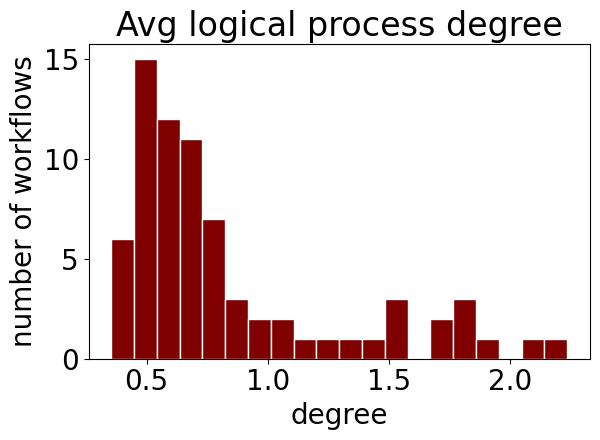

In [3]:
import csv
import matplotlib.pyplot as plt

counts = []
with open('./results/in_out_degree_ratio_processes.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        try:
            count = float(row[1])
            counts.append(count)
        except ValueError:
            print(f"Skipping row with non-numeric value in the specified column: {row}")

plt.rc('font', size=20)
plt.hist(counts, bins=20,color='maroon', edgecolor='white')
plt.title('Avg logical process degree')
plt.xlabel('degree')
plt.ylabel('number of workflows')
plt.tight_layout()
plt.savefig(f'./plots/avg_process_degree.png', format="png", bbox_inches='tight')
plt.show()

In [ ]:
import os
import csv
import networkx as nx

def get_processes_degree(dot_file):
    G = nx.nx_agraph.read_dot(dot_file)
    
    processes = [node for node in G.nodes() if 'shape' not in G.nodes[node]]
    
    process_data = []
    for node in processes:
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)
        
        # e.g.: if its 2 in and 0 out -> we take the 2
        ratio = in_degree / out_degree if out_degree != 0 else in_degree
        
        process_data.append((node, in_degree, out_degree, ratio))
    
    return process_data

directory_path = './dags'
output_file = './results/processes_degrees.csv'

with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['pipeline', 'node', 'in_degree', 'out_degree', 'in_out_degree_ratio'])
    
    for filename in os.listdir(directory_path):
        if filename.endswith(".dot"):
            dot_file_path = os.path.join(directory_path, filename)
            process_data = get_processes_degree(dot_file_path)
            
            file_name = filename.split('_')[0]
            
            for node, in_degree, out_degree, ratio in process_data:
                writer.writerow([file_name, node, in_degree, out_degree, ratio])

print(f'Results written to: {output_file}')

In [3]:
df_degree = pd.read_csv('./results/processes_degrees.csv')
#pd.set_option('display.max_rows', None) # max pipelines: amliseq 37, viralrecon, rnaseq 37
df_degree.describe()

,in_degree,out_degree,in_out_degree_ratio
count,2211.000000,2211.000000,2211.000000
mean,2.058797,3.440072,0.827782
std,2.447305,4.013259,1.224450
min,0.000000,0.000000,0.000000
25%,1.000000,2.000000,0.333333
50%,1.000000,3.000000,0.500000
75%,2.000000,4.000000,1.000000
max,49.000000,63.000000,29.000000


In [ ]:
df = pd.read_csv(output_file)

max_ratios = {}
for _, row in df.iterrows():
    pipeline = row['pipeline']
    ratio = row['in_degree']
    
    if pipeline not in max_ratios or ratio > max_ratios[pipeline]:
        max_ratios[pipeline] = ratio

max_ratios_df = pd.DataFrame(list(max_ratios.items()), columns=['pipeline', 'in_degree'])

print(max_ratios_df)

max_ratios_df.to_csv('./results/max_in_degree_processes.csv', index=False)

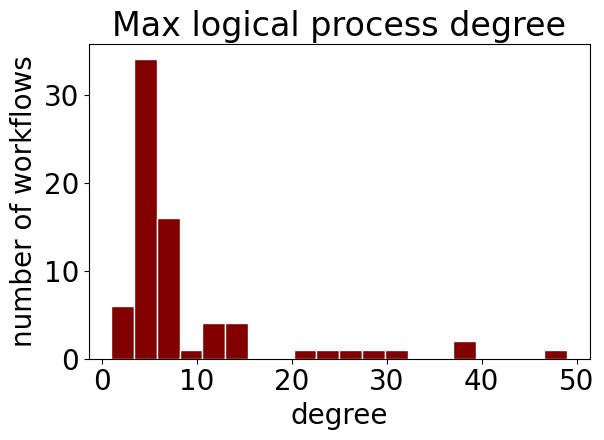

In [6]:
import csv
import matplotlib.pyplot as plt

max_degree = []

with open('./results/max_in_degree_processes.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        try:
            degree = float(row[1])
            max_degree.append(degree)
        except ValueError:
            print(f"Skipping row with non-numeric value in the specified column: {row}")

plt.rc('font', size=20)
plt.hist(max_degree, bins=20, color='maroon', edgecolor='white')
plt.title('Max logical process degree')
plt.xlabel('degree')
plt.ylabel('number of workflows')
plt.tight_layout()
plt.savefig(f'{directory_plots}/max_process_degree.png', format="png", bbox_inches='tight')
plt.show()

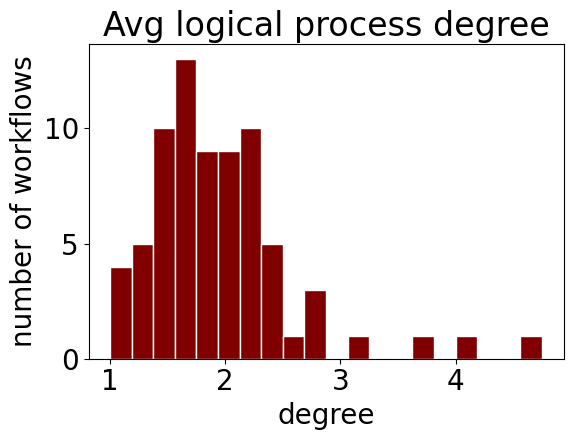

In [4]:
import csv
import matplotlib.pyplot as plt
import pandas as pd

in_degrees = {}

with open('./results/processes_degrees.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
        try:
            pipeline = row[0]
            in_degree = float(row[2]) # in degree
            
            if pipeline not in in_degrees:
                in_degrees[pipeline] = []
            in_degrees[pipeline].append(in_degree)
        except ValueError:
            print(f"Skipping row with non-numeric value in the specified column: {row}")

avg_in_degrees = {pipeline: sum(degrees) / len(degrees) for pipeline, degrees in in_degrees.items()}

# Plot the histogram
plt.rc('font', size=20)
plt.hist(avg_in_degrees.values(), bins=20, color='maroon', edgecolor='white')
plt.title('Avg logical process degree')
plt.xlabel('degree')
plt.ylabel('number of workflows')
plt.tight_layout()
plt.savefig(f'{directory_plots}/avg_in_degree.png', format="png", bbox_inches='tight')
plt.show()

# Usage of Queue channel vs. Value channel keywords in DAGs

We want to check the xlabel of each value/channel node to compare it to the dags. Just run the cell below, all imports and parths are assigned again.

Before we checked like that: 
queue_channels = ['Channel.of', 'Channel.fromPath', 'Channel.empty', 'map', 'flatMap', 'ifEmpty', 'join']
value_channels = ['first', 'collect', 'reduce']

In [ ]:
import os
import csv
import networkx as nx

def extract_xlabels_from_dot_file(dot_file, channel_list):
    G = nx.nx_agraph.read_dot(dot_file)

    matching_nodes = []
    for node, data in G.nodes(data=True):
        if 'xlabel' in data and data['xlabel'] in channel_list:
            matching_nodes.append({
                'pipeline': os.path.basename(dot_file).split('_')[0],
                'node': node,
                'operator_label': data['xlabel'],
                'operator': 'queue channel' if data['xlabel'] in queue_channels else 'value channel'
            })
    return matching_nodes

def count_nodes_by_labels(dot_file, channel_list):
    matching_nodes = extract_xlabels_from_dot_file(dot_file, channel_list)
    return len(matching_nodes), matching_nodes

def iterate_over_dot_files(directory_path, queue_channels, value_channels):
    all_queue_nodes = []
    all_value_nodes = []
    results_list = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".dot"):
            dot_file_path = os.path.join(directory_path, filename)
            pipeline_name = os.path.basename(filename).split('_')[0]
            
            queue_count, queue_matching_nodes = count_nodes_by_labels(dot_file_path, queue_channels)
            all_queue_nodes.extend(queue_matching_nodes)

            value_count, value_matching_nodes = count_nodes_by_labels(dot_file_path, value_channels)
            all_value_nodes.extend(value_matching_nodes)

    results_list.extend(all_queue_nodes)
    results_list.extend(all_value_nodes)

    return results_list

directory_path = './dags'
queue_channels = ['Channel.of', 'Channel.fromPath', 'Channel.empty', 'map', 'flatMap', 'ifEmpty', 'join']
value_channels = ['first', 'collect', 'reduce']

results_list = iterate_over_dot_files(directory_path, queue_channels, value_channels)

csv_operator_path = './results/operator_channels_counts_with_label.csv'
header = ['pipeline', 'node', 'operator_label', 'operator']

with open(csv_operator_path, 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=header)
    writer.writeheader()
    writer.writerows(results_list)

print(f'Results written to: {csv_operator_path}')

In [ ]:
import pandas as pd

df_operators = pd.read_csv('./results/operator_channels_counts_with_label.csv')
label_counts = df_operators['operator_label'].value_counts()

print('Distinct Labels and Their Sum of Counts:')
print(label_counts)

In [ ]:
import pandas as pd

df_operators = pd.read_csv('./results/operator_channels_counts_with_label.csv')


queue_operators = df_operators[df_operators['operator'] == 'queue channel']
value_operators = df_operators[df_operators['operator'] == 'value channel']


print(f'Sum of queue operator nodes in DAGs {len(queue_operators)}')
print(f'Sum of value operator nodes in DAGs {len(value_operators)}')

In [ ]:
different_pipelines = df_operators.groupby('operator')['pipeline'].nunique()
print(different_pipelines)

In [ ]:
different_pipelines = df_operators.groupby('operator_label')['pipeline'].nunique()
print(different_pipelines)

# We focus on all nextflow channel operators here: (https://www.nextflow.io/docs/latest/operator.html)

In [ ]:
import os
import csv
import networkx as nx
import pandas as pd

def extract_xlabels_from_dot_file(dot_file, channel_list):
    G = nx.nx_agraph.read_dot(dot_file)

    matching_nodes = []
    for node, data in G.nodes(data=True):
        if 'xlabel' in data and data['xlabel'] in channel_list:
            matching_nodes.append({
                'pipeline': os.path.basename(dot_file).split('_')[0],
                'node': node,
                'operator_label': data['xlabel'],
                'operator': 'queue channel' if data['xlabel'] in queue_channels else 'value channel'
            })
    return matching_nodes

def count_nodes_by_labels(dot_file, channel_list):
    matching_nodes = extract_xlabels_from_dot_file(dot_file, channel_list)
    return len(matching_nodes), matching_nodes

def iterate_over_dot_files(directory_path, queue_channels, value_channels):
    all_queue_nodes = []
    all_value_nodes = []
    results_list = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".dot"):
            dot_file_path = os.path.join(directory_path, filename)
            pipeline_name = os.path.basename(filename).split('_')[0]
            
            queue_count, queue_matching_nodes = count_nodes_by_labels(dot_file_path, queue_channels)
            all_queue_nodes.extend(queue_matching_nodes)

            value_count, value_matching_nodes = count_nodes_by_labels(dot_file_path, value_channels)
            all_value_nodes.extend(value_matching_nodes)

    results_list.extend(all_queue_nodes)
    results_list.extend(all_value_nodes)

    return results_list

directory_path = './dags'

df = pd.read_csv('./data/nextflow_operators.csv')
queue_channels = df[df['operator_type'] == 'queue']['operator'].tolist()
value_channels = df[df['operator_type'] == 'value']['operator'].tolist()

results_list = iterate_over_dot_files(directory_path, queue_channels, value_channels)

csv_operator_path = './results/nextflow_operators_dags.csv'
header = ['pipeline', 'node', 'operator_label', 'operator']

with open(csv_operator_path, 'w', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=header)
    writer.writeheader()
    writer.writerows(results_list)

print(f'Results written to: {csv_operator_path}')

In [ ]:
import pandas as pd

df_nextflow_op = pd.read_csv('./results/nextflow_operators_dags.csv')

grouped = df.groupby('operator_type')['operator'].count()
print(grouped)

In [ ]:
operator_counts = df_nextflow_op['operator_label'].value_counts()

print('Distinct Labels and Their Sum of Counts:')
print(operator_counts)

In [ ]:
import pandas as pd

df_operators = pd.read_csv('./results/nextflow_operators_dags.csv')


queue_operators = df_operators[df_operators['operator'] == 'queue channel']
value_operators = df_operators[df_operators['operator'] == 'value channel']


print(f'Sum of queue operator nodes in DAGs {len(queue_operators)}')
print(f'Sum of value operator nodes in DAGs {len(value_operators)}')

# Nextflow operators in processes (in GitHub repositories)

In [8]:
import os
import re
import csv
import pandas as pd

def find_operators_in_processes(directory, pattern_list, output_file_name):
    result_list = []

    for pipeline in os.listdir(directory):
        subdirectory_path = os.path.join(directory, pipeline)
        folder_name = os.path.basename(subdirectory_path)

        for root, dirs, files in os.walk(subdirectory_path):
            for filename in files:
                file_path = os.path.join(root, filename)
                
                if filename.endswith('.nf') or filename.endswith('.config'):
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                        lines = file.readlines()
                    
                    process_flag = False
                    process_name = None
                    brace_stack = []

                    process_pattern = r'workflow\s+(\w+)\s*{'

                    for line_num, line in enumerate(lines):
                        stripped_line = line.strip()
                        
                        if line.strip().startswith('#') or line.strip().startswith('//') or line.strip().startswith('*'):
                                continue

                        if re.search(process_pattern, stripped_line):
                            process_flag = True
                            process_match = re.search(process_pattern, stripped_line)
                            if process_match:
                                process_name = process_match.group(1)
                            print(f'Process {process_name} in filepath {file_path}')
                            brace_stack.append('{')

                        if '{' in stripped_line:
                            brace_stack.append('{')

                        if '}' in stripped_line:
                            if brace_stack:
                                brace_stack.pop()
                                if not brace_stack and process_flag:
                                    process_flag = False

                        if process_flag:
                            pattern_found = False
                            for pattern in pattern_list:
                                regex_pattern = re.compile(r'\.' + re.escape(pattern) + r'(?!\w)' , re.IGNORECASE)
                                if regex_pattern.search(stripped_line):
                                    result_list.append([folder_name, process_name, pattern, file_path, line_num+1, stripped_line])
                                    print(f'Nextflow operator {pattern} with content: {stripped_line}')
                                    pattern_found = True
                                    break
                            if not pattern_found:
                                result_list.append([folder_name, process_name, 'none', file_path, 'none', 'none'])

                    if brace_stack:
                        print("Error: Unclosed process block in file:", file_path)

    with open(f'./results/{output_file_name}.csv', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['pipeline', 'workflow', 'operator', 'file_path', 'line_number', 'line_content'])
        writer.writerows(result_list)

In [9]:
directory_path = './git_repos'

df_operators = pd.read_csv('./data/nextflow_operators.csv')
pattern_list = [re.escape(str(pattern)) for pattern in df_operators['operator']]

output_file_name = 'nextflow_operators_in_workflow'

find_operators_in_processes(directory_path, pattern_list, output_file_name)

Process NFCORE_AIRRFLOW in filepath ./git_repos\airrflow\main.nf
Error: Unclosed process block in file: ./git_repos\airrflow\main.nf
Process ASSEMBLED_INPUT_CHECK in filepath ./git_repos\airrflow\subworkflows\local\assembled_input_check.nf
Nextflow operator splitCsv with content: .splitCsv(header: true, sep:'\t')
Nextflow operator map with content: .map { get_meta(it) }
Nextflow operator branch with content: .branch { it ->
Nextflow operator set with content: .set{ ch_metadata }
Error: Unclosed process block in file: ./git_repos\airrflow\subworkflows\local\assembled_input_check.nf
Process BULK_QC_AND_FILTER in filepath ./git_repos\airrflow\subworkflows\local\bulk_qc_and_filter.nf
Nextflow operator collect with content: ch_imgt.collect()
Nextflow operator mix with content: ch_logs = ch_logs.mix(CHANGEO_CREATEGERMLINES.out.logs)
Nextflow operator ifEmpty with content: ch_versions = ch_versions.mix(CHANGEO_CREATEGERMLINES.out.versions.ifEmpty(null))
Nextflow operator collect with content:

Error: Unclosed process block in file: ./git_repos\airrflow\workflows\airrflow.nf
Process NFCORE_AMPLISEQ in filepath ./git_repos\ampliseq\main.nf
Error: Unclosed process block in file: ./git_repos\ampliseq\main.nf
Process CUTADAPT_WORKFLOW in filepath ./git_repos\ampliseq\subworkflows\local\cutadapt_workflow.nf
Nextflow operator set with content: CUTADAPT_BASIC ( ch_file ).reads.set { ch_trimmed_reads }
Nextflow operator map with content: .map {
Nextflow operator groupTuple with content: .groupTuple(by: 0 )
Nextflow operator set with content: .set { ch_cutadapt_logs }
Nextflow operator set with content: CUTADAPT_READTHROUGH ( ch_trimmed_reads ).reads.set { ch_trimmed_reads }
Nextflow operator set with content: CUTADAPT_DOUBLEPRIMER ( ch_trimmed_reads ).reads.set { ch_trimmed_reads }
Nextflow operator map with content: .map {
Nextflow operator groupTuple with content: .groupTuple(by: 0 )
Nextflow operator set with content: .set { ch_cutadapt_doubleprimer_logs }
Nextflow operator combin

Process PHYLOSEQ_WORKFLOW in filepath ./git_repos\ampliseq\subworkflows\local\phyloseq_workflow.nf
Nextflow operator first with content: ch_phyloseq_inmeta = ch_meta.first() // The .first() is to make sure it's a value channel
Nextflow operator first with content: ch_phyloseq_intree = ch_tree.map { it = it[1] }.first()
Nextflow operator combine with content: PHYLOSEQ ( ch_tax.combine(ch_phyloseq_inasv), ch_phyloseq_inmeta, ch_phyloseq_intree )
Error: Unclosed process block in file: ./git_repos\ampliseq\subworkflows\local\phyloseq_workflow.nf
Process QIIME2_ANCOM in filepath ./git_repos\ampliseq\subworkflows\local\qiime2_ancom.nf
Nextflow operator combine with content: .combine( ch_asv )
Nextflow operator combine with content: .combine( ch_metacolumn_all )
Nextflow operator set with content: .set{ ch_for_filtersamples }
Nextflow operator combine with content: .combine( QIIME2_FILTERSAMPLES_ANCOM.out.qza )
Nextflow operator combine with content: .combine( ch_tax )
Nextflow operator combi

Process ALIGN_STAR in filepath ./git_repos\atacseq\subworkflows\local\align_star.nf
Nextflow operator first with content: ch_versions = ch_versions.mix(STAR_ALIGN.out.versions.first())
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_SORT_STATS_SAMTOOLS.out.versions)
Error: Unclosed process block in file: ./git_repos\atacseq\subworkflows\local\align_star.nf
Process BAM_BEDGRAPH_BIGWIG_BEDTOOLS_UCSC in filepath ./git_repos\atacseq\subworkflows\local\bam_bedgraph_bigwig_bedtools_ucsc.nf
Nextflow operator first with content: ch_versions = ch_versions.mix(BEDTOOLS_GENOMECOV.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(UCSC_BEDGRAPHTOBIGWIG.out.versions.first())
Error: Unclosed process block in file: ./git_repos\atacseq\subworkflows\local\bam_bedgraph_bigwig_bedtools_ucsc.nf
Process BAM_FILTER_BAMTOOLS in filepath ./git_repos\atacseq\subworkflows\local\bam_filter_bamtools.nf
Nextflow operator first with content: ch_versions =

Nextflow operator mix with content: ch_versions = ch_versions.mix(ALIGN_STAR.out.versions)
Nextflow operator map with content: .map {
Nextflow operator groupTuple with content: .groupTuple(by: [0])
Nextflow operator map with content: .map {
Nextflow operator flatten with content: [ meta, bam.flatten() ]
Nextflow operator set with content: .set { ch_sort_bam }
Nextflow operator first with content: ch_versions = ch_versions.mix(PICARD_MERGESAMFILES_LIBRARY.out.versions.first())
Nextflow operator map with content: .map {
Nextflow operator map with content: .map {
Nextflow operator mix with content: ch_versions = ch_versions.mix(MERGED_LIBRARY_MARKDUPLICATES_PICARD.out.versions)
Nextflow operator join with content: MERGED_LIBRARY_MARKDUPLICATES_PICARD.out.bam.join(MERGED_LIBRARY_MARKDUPLICATES_PICARD.out.bai, by: [0]),
Nextflow operator first with content: PREPARE_GENOME.out.filtered_bed.first(),
Nextflow operator map with content: .map {
Nextflow operator mix with content: ch_versions = c

Process INPUT_CHECK in filepath ./git_repos\bactmap\subworkflows\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channels(it) }
Nextflow operator set with content: .set { sample_info }
Error: Unclosed process block in file: ./git_repos\bactmap\subworkflows\input_check.nf
Process SUB_SAMPLING in filepath ./git_repos\bactmap\subworkflows\sub_sampling.nf
Nextflow operator combine with content: reads_and_genome_size = reads.combine([params.genome_size])
Nextflow operator map with content: genome_size = MASH_SKETCH.out.stats.map { meta, file -> [meta, WorkflowBactmap.find_genome_size(file.text)]}
Nextflow operator combine with content: reads_and_genome_size = reads.combine(genome_size, by: 0)
Nextflow operator first with content: version = params.genome_size ? RASUSA.out.version : MASH_SKETCH.out.version.mix(RASUSA.out.version.first().ifEmpty(null)) //    path: *.version.txt
Error: Unclosed pr

Process ALIGN in filepath ./git_repos\callingcards\subworkflows\local\align.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(BWAMEM2_MEM.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(SAMTOOLS_INDEX.out.versions)
Nextflow operator join with content: .join(SAMTOOLS_INDEX.out.bai)
Nextflow operator set with content: .set{ ch_tmp }
Nextflow operator mix with content: ch_bam = ch_bam.mix(ch_tmp)
Nextflow operator mix with content: ch_versions = ch_versions.mix(FASTQ_ALIGN_BWAALN.out.versions)
Nextflow operator join with content: .join(FASTQ_ALIGN_BWAALN.out.bai)
Nextflow operator set with content: .set{ ch_tmp }
Nextflow operator mix with content: ch_bam = ch_bam.mix(ch_tmp)
Nextflow operator mix with content: ch_versions = ch_versions.mix(BOWTIE2_ALIGN.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(SAMTOOLS_INDEX.out.versions)
Nextflow operator join with content: .join(SAMTOOLS_INDEX.out.bai)
Nextflow op

Error: Unclosed process block in file: ./git_repos\callingcards\subworkflows\nf-core\fastq_align_bwaaln\main.nf
Process CALLINGCARDS_MAMMALS in filepath ./git_repos\callingcards\workflows\callingcards_mammals.nf
Nextflow operator multiMap with content: .multiMap{ sample, fastq_1, fastq_2, barcode_details ->
Nextflow operator set with content: .set{ ch_input }
Nextflow operator mix with content: ch_versions = ch_versions.mix(PREPARE_GENOME.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(PREPARE_READS.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(ALIGN.out.versions)
Nextflow operator map with content: .map{meta, bam, bai -> [meta.id, meta, bam, bai] }
Nextflow operator combine with content: .combine(ch_input.barcode_details
Nextflow operator map with content: .map{meta, barcode_details ->
Nextflow operator map with content: .map{id, meta, bam, bai, barcode_details ->
Nextflow operator set with content: .set{ ch_aln_with_de

Process MARK_DUPLICATES_PICARD in filepath ./git_repos\chipseq\subworkflows\nf-core\mark_duplicates_picard.nf
Nextflow operator first with content: ch_versions = ch_versions.mix(PICARD_MARKDUPLICATES.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(SAMTOOLS_INDEX.out.versions.first())
Nextflow operator join with content: BAM_STATS_SAMTOOLS(PICARD_MARKDUPLICATES.out.bam.join(SAMTOOLS_INDEX.out.bai, by: [0]))
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_STATS_SAMTOOLS.out.versions)
Error: Unclosed process block in file: ./git_repos\chipseq\subworkflows\nf-core\mark_duplicates_picard.nf
Process CHIPSEQ in filepath ./git_repos\chipseq\workflows\chipseq.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(PREPARE_GENOME.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(FASTQC_TRIMGALORE.out

Nextflow operator map with content: .map { meta, fastq -> [ meta + [single_end: true], fastq ] }
Nextflow operator set with content: .set { ch_circular_fastq }
Nextflow operator mix with content: ch_versions = ch_versions.mix(MINIMAP2_ALIGN.out.versions)
Nextflow operator collectFile with content: ch_versions.unique().collectFile(name: 'collated_versions.yml')
Nextflow operator collect with content: ch_multiqc_custom_config.collect().ifEmpty([]),
Nextflow operator collect with content: CUSTOM_DUMPSOFTWAREVERSIONS.out.mqc_yml.collect(),
Nextflow operator collectFile with content: ch_workflow_summary.collectFile(name: 'workflow_summary_mqc.yaml'),
Nextflow operator collect with content: ch_fastqc_multiqc.collect{it[1]}.ifEmpty([]),
Nextflow operator collect with content: ch_trimgalore_multiqc.collect{it[1]}.ifEmpty([]),
Nextflow operator collect with content: ch_trimgalore_multiqc_log.collect{it[1]}.ifEmpty([]),
Nextflow operator collect with content: ch_samtools_stats.collect{it[1]}.ifE

Process CIRCRNA in filepath ./git_repos\circrna\workflows\circrna.nf
Nextflow operator map with content: .map {
Nextflow operator join with content: meta.id = meta.id.split('_')[0..-2].join('_')
Nextflow operator groupTuple with content: .groupTuple(by: [0])
Nextflow operator branch with content: .branch {
Nextflow operator flatten with content: return [ meta, fastq.flatten() ]
Nextflow operator flatten with content: return [ meta, fastq.flatten() ]
Nextflow operator set with content: .set { ch_fastq }
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator mix with content: .mix(ch_fastq.single)
Nextflow operator set with content: .set { ch_cat_fastq }
Nextflow operator first with content: ch_versions = ch_versions.mix(CAT_FASTQ.out.versions.first().ifEmpty(null))
Nextflow operator map with content: bowtie2_index  = params.fasta ? params.bowtie2 ? Channel.fromPath(params.bowtie2).map{ it -> [[id:'bowtie2'], it] } : PREPARE_GENOME.o

Process CRISPRSEQ_SCREENING in filepath ./git_repos\crisprseq\workflows\crisprseq_screening.nf
Nextflow operator map with content: .map{ meta, fastq_1, fastq_2, x, y, z ->
Nextflow operator set with content: .set { ch_input }
Nextflow operator first with content: ch_versions = ch_versions.mix(FASTQC.out.versions.first())
Nextflow operator combine with content: ch_input_cutadapt = ch_input.combine(Channel.value([[]]))
Nextflow operator mix with content: ch_versions = ch_versions.mix(CUTADAPT.out.versions)
Nextflow operator map with content: .map{ meta, fastq  ->
Nextflow operator set with content: .set { ch_input }
Nextflow operator map with content: .map { meta, fastqs  ->
Nextflow operator reduce with content: .reduce { a, b ->
Nextflow operator map with content: .map { condition, fastqs_1, single_end, fastqs_2 ->
Nextflow operator last with content: .last()
Nextflow operator set with content: .set { joined }
Nextflow operator first with content: ch_versions = ch_versions.mix(MAGECK_C

Process ALIGN_BOWTIE2 in filepath ./git_repos\cutandrun\subworkflows\local\align_bowtie2.nf
Nextflow operator map with content: ch_index = index.map { [[id:it.baseName], it] }
Nextflow operator collect with content: ch_index.collect{ it[1] },
Nextflow operator mix with content: ch_versions = ch_versions.mix(BOWTIE2_TARGET_ALIGN.out.versions)
Nextflow operator map with content: ch_spikein_index = spikein_index.map { [[id:it.baseName], it] }
Nextflow operator collect with content: ch_spikein_index.collect{ it[1] },
Nextflow operator mix with content: ch_versions = ch_versions.mix(BOWTIE2_SPIKEIN_ALIGN.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_SORT_STATS_SAMTOOLS.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_SORT_STATS_SAMTOOLS_SPIKEIN.out.versions)
Error: Unclosed process block in file: ./git_repos\cutandrun\subworkflows\local\align_bowtie2.nf
Process CONSENSUS_PEAKS in filepath ./git_repos\cutandrun\subworkf

Nextflow operator collect with content: PREPARE_GENOME.out.fasta.collect(),
Nextflow operator collect with content: PREPARE_GENOME.out.fasta_index.collect(),
Nextflow operator mix with content: ch_software_versions      = ch_software_versions.mix(DEDUPLICATE_LINEAR.out.versions)
Nextflow operator collect with content: PREPARE_GENOME.out.chrom_sizes.collect(),
Nextflow operator mix with content: ch_software_versions = ch_software_versions.mix(PREPARE_PEAKCALLING.out.versions)
Nextflow operator filter with content: ch_bedgraph.filter { it -> it[0].is_control == false }
Nextflow operator set with content: .set { ch_bedgraph_target }
Nextflow operator filter with content: ch_bedgraph.filter { it -> it[0].is_control == true }
Nextflow operator set with content: .set { ch_bedgraph_control }
Nextflow operator filter with content: ch_samtools_bam.filter { it -> it[0].is_control == false }
Nextflow operator set with content: .set { ch_bam_target }
Nextflow operator filter with content: ch_samto

Process DEMULTIPLEX in filepath ./git_repos\demultiplex\workflows\demultiplex.nf
Nextflow operator dump with content: ch_inputs.dump(tag: 'DEMULTIPLEX::inputs',{FormattingService.prettyFormat(it)})
Nextflow operator branch with content: .branch { meta, samplesheet, run, manifest ->
Nextflow operator multiMap with content: .multiMap { meta, samplesheet, run, manifest ->
Nextflow operator dump with content: ch_inputs.dump(tag: 'DEMULTIPLEX::inputs',{FormattingService.prettyFormat(it)})
Nextflow operator branch with content: .branch { meta, samplesheet, run ->
Nextflow operator multiMap with content: .multiMap { meta, samplesheet, run ->
Nextflow operator join with content: if (demultiplexer in ['bclconvert', 'bcl2fastq']) ch_flowcells_tar_merged = ch_flowcells_tar.samplesheets.join(ch_flowcells_tar.run_dirs, failOnMismatch:true, failOnDuplicate:true)
Nextflow operator join with content: ch_flowcells_tar_merged = ch_flowcells_tar.samplesheets.join( UNTAR ( ch_flowcells_tar.run_dirs ).unta

Process DIFFERENTIALABUNDANCE in filepath ./git_repos\differentialabundance\workflows\differentialabundance.nf
Nextflow operator join with content: .join(UNTAR.out.untar)
Nextflow operator mix with content: .mix(AFFY_JUSTRMA_RAW.out.versions)
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:(params.contrasts.endsWith('tsv') ? '\t' : ','))
Nextflow operator first with content: .map{ it.tail().first() }
Nextflow operator map with content: .map{
Nextflow operator unique with content: .unique()   // uniquify to keep each contrast variable only once (in case it exists in multiple lines for blocking etc.)
Nextflow operator combine with content: ch_contrast_variables.combine(proteus_in)
Nextflow operator first with content: .first()
Nextflow operator map with content: .map{ meta, matrix -> tuple(exp_meta, matrix) }
Nextflow operator first with content: .first()
Nextflow operator map with content: .map{ meta, matrix -> tuple(exp_meta, matrix) }
Nextflow operator mix with c

Nextflow operator ifEmpty with content: ch_versions = ch_versions.mix( MERGE_JSON_MULTI.out.versions.ifEmpty(null) )
Nextflow operator collectFile with content: ch_versions.unique().collectFile(name: 'collated_versions.yml')
Nextflow operator collectFile with content: ch_multiqc_files = ch_multiqc_files.mix(ch_workflow_summary.collectFile(name: 'workflow_summary_mqc.yaml'))
Nextflow operator collectFile with content: ch_multiqc_files = ch_multiqc_files.mix(ch_methods_description.collectFile(name: 'methods_description_mqc.yaml'))
Nextflow operator collect with content: ch_multiqc_files = ch_multiqc_files.mix(CUSTOM_DUMPSOFTWAREVERSIONS.out.mqc_yml.collect())
Nextflow operator collect with content: ch_multiqc_files.collect(),
Nextflow operator toList with content: ch_multiqc_config.toList(),
Nextflow operator toList with content: ch_multiqc_custom_config.toList(),
Nextflow operator toList with content: ch_multiqc_logo.toList()
Nextflow operator toList with content: multiqc_report = MULTI

Process FUNCSCAN in filepath ./git_repos\funcscan\workflows\funcscan.nf
Nextflow operator branch with content: .branch {
Nextflow operator mix with content: ch_versions = ch_versions.mix(GUNZIP_FASTA_PREP.out.versions)
Nextflow operator mix with content: .mix(fasta_prep.uncompressed)
Nextflow operator mix with content: ch_versions = ch_versions.mix(BIOAWK.out.versions)
Nextflow operator join with content: .join( BIOAWK.out.longest )
Nextflow operator map with content: .map{
Nextflow operator mix with content: ch_versions              = ch_versions.mix(PRODIGAL_GFF.out.versions)
Nextflow operator mix with content: ch_versions              = ch_versions.mix(PRODIGAL_GBK.out.versions)
Nextflow operator mix with content: ch_versions              = ch_versions.mix(PYRODIGAL.out.versions)
Nextflow operator mix with content: ch_versions              = ch_versions.mix(PROKKA.out.versions)
Nextflow operator first with content: .first()
Nextflow operator mix with content: ch_versions = ch_versio

Process PASA_PIPELINE in filepath ./git_repos\genomeannotator\subworkflows\local\pasa_pipeline.nf
Error: Unclosed process block in file: ./git_repos\genomeannotator\subworkflows\local\pasa_pipeline.nf
Process REPEATMASKER in filepath ./git_repos\genomeannotator\subworkflows\local\repeatmasker.nf
Nextflow operator map with content: GUNZIP.out.gunzip.map {m,g -> g}
Nextflow operator collect with content: REPEATMASKER_STAGELIB.out.library.collect().map{it[0].toString()},
Nextflow operator collect with content: rm_lib.collect(),
Nextflow operator mix with content: versions = REPEATMASKER_STAGELIB.out.versions.mix(REPEATMASKER_REPEATMASK.out.versions,FASTASPLITTER.out.versions,REPEATMASKER_CAT_FASTA.out.versions)
Error: Unclosed process block in file: ./git_repos\genomeannotator\subworkflows\local\repeatmasker.nf
Process RNASEQ_ALIGN in filepath ./git_repos\genomeannotator\subworkflows\local\rnaseq_align.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow

Process INPUT_CHECK in filepath ./git_repos\genomeskim\subworkflows\local\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channel(it) }
Nextflow operator set with content: .set { reads }
Error: Unclosed process block in file: ./git_repos\genomeskim\subworkflows\local\input_check.nf
Process GENOMESKIM in filepath ./git_repos\genomeskim\workflows\genomeskim.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator first with content: ch_versions = ch_versions.mix(FASTQC.out.versions.first())
Nextflow operator collectFile with content: ch_versions.unique().collectFile(name: 'collated_versions.yml')
Nextflow operator mix with content: ch_multiqc_files = ch_multiqc_files.mix(Channel.from(ch_multiqc_config))
Nextflow operator collect with content: ch_multiqc_files = ch_multiqc_files.mix(ch_multiqc_custom_config.collect().ifEmpty([]))
Nextfl

Process NFCORE_HICAR in filepath ./git_repos\hicar\main.nf
Error: Unclosed process block in file: ./git_repos\hicar\main.nf
Process APA in filepath ./git_repos\hicar\subworkflows\local\apa.nf
Error: Unclosed process block in file: ./git_repos\hicar\subworkflows\local\apa.nf
Process BAM_STAT in filepath ./git_repos\hicar\subworkflows\local\bam_stats.nf
Nextflow operator join with content: ch_bam_bai = SAMTOOLS_SORT.out.bam.join(SAMTOOLS_INDEX.out.bai, by: [0])
Error: Unclosed process block in file: ./git_repos\hicar\subworkflows\local\bam_stats.nf
Process ATAC_PEAK in filepath ./git_repos\hicar\subworkflows\local\callatacpeak.nf
Nextflow operator mix with content: ch_version = ch_version.mix(SHIFT_READS.out.versions)
Nextflow operator map with content: .map{meta, bed -> [meta.group, bed]}
Nextflow operator groupTuple with content: .groupTuple()
Nextflow operator map with content: .map{it -> [[id:it[0]], it[1]]} // id is group
Nextflow operator set with content: .set{read4merge}
Nextflow

Process PAIRTOOLS_PAIRE in filepath ./git_repos\hicar\subworkflows\local\pairtools.nf
Nextflow operator map with content: counts = PAIRTOOLS_PARSE.out.stat.map{
Nextflow operator first with content: .first().replaceAll(/cis_20kb.\s+/, '')
Nextflow operator join with content: .join(COVERAGE_SCALE.out.scale)
Nextflow operator map with content: rawstat.map{meta, stat -> [meta.id, meta, stat]}
Nextflow operator join with content: .join(PAIRTOOLS_DEDUP.out.stat.map{meta, stat -> [meta.id, stat]})
Nextflow operator map with content: .map{id, meta, raw, dedup -> [meta, raw, dedup ]}
Nextflow operator set with content: .set{ reads_stat }
Nextflow operator map with content: READS_SUMMARY(READS_STAT.out.stat.map{it[1]}
Nextflow operator map with content: .mix(PAIRSPLOT.out.summary.map{it[1]})
Nextflow operator collect with content: .mix(PAIRSPLOT.out.csv.map{it[1]}).collect())
Error: Unclosed process block in file: ./git_repos\hicar\subworkflows\local\pairtools.nf
Process PREPARE_GENOME in filep

Nextflow operator groupTuple with content: .groupTuple()
Nextflow operator combine with content: .combine(RECENTER_PEAK.out.peak)
Nextflow operator set with content: .set{ch_chic_explorer}
Nextflow operator combine with content: HICEXPLORER_CHICVIEWPOINT(HICEXPLORER_CHICQUALITYCONTROL.out.referencepoints.combine(HICEXPLORER_CHICVIEWPOINTBACKGROUNDMODEL.out.background_model, by: 0))
Nextflow operator combine with content: ch_comp_additional = PREPARE_GENOME.out.fasta.combine(PREPARE_GENOME.out.chrom_sizes)
Nextflow operator map with content: PAIRTOOLS_PAIRE.out.homerpair.map{
Nextflow operator groupTuple with content: }.groupTuple(by:0)
Nextflow operator combine with content: ch_comp_additional = homer_genome.combine(PREPARE_GENOME.out.chrom_sizes)
Nextflow operator ifEmpty with content: ch_versions = ch_versions.mix(CAT_CAT.out.versions.ifEmpty(null))
Nextflow operator ifEmpty with content: ch_versions = ch_versions.mix(HOMER_MAKETAGDIRECTORY.out.versions.ifEmpty(null))
Nextflow operat

Process NFCORE_MAG in filepath ./git_repos\mag\main.nf
Error: Unclosed process block in file: ./git_repos\mag\main.nf
Process ANCIENT_DNA_ASSEMBLY_VALIDATION in filepath ./git_repos\mag\subworkflows\local\ancient_dna.nf
Nextflow operator map with content: PYDAMAGE_ANALYZE(input.map {item -> [item[0], item[2], item[3]]})
Nextflow operator first with content: ch_versions = ch_versions.mix(PYDAMAGE_ANALYZE.out.versions.first())
Nextflow operator map with content: FAIDX(input.map { item -> [ item[0], item[1] ] }, [[],[]] )
Nextflow operator join with content: freebayes_input = input.join(FAIDX.out.fai)  // [val(meta), path(contigs), path(bam), path(bam_index), path(fai)]
Nextflow operator multiMap with content: .multiMap{
Nextflow operator join with content: BCFTOOLS_VIEW(FREEBAYES.out.vcf.join(BCFTOOLS_INDEX_PRE.out.tbi), [], [], [])
Nextflow operator join with content: .join(BCFTOOLS_INDEX_POST.out.tbi)
Nextflow operator join with content: .join(input.map { item -> [ item[0], item[1] ] }

Nextflow operator mix with content: .mix(ch_archaea_bins)
Nextflow operator mix with content: .mix(ch_organelle_bins)
Nextflow operator mix with content: .mix(ch_unknown_bins)
Nextflow operator filter with content: .filter { meta, bins ->
Nextflow operator map with content: .map { meta, bins ->
Nextflow operator filter with content: .filter { meta, bins ->
Nextflow operator map with content: .map { meta, bins ->
Nextflow operator map with content: .map { meta, classification ->
Nextflow operator collect with content: .collect()
Error: Unclosed process block in file: ./git_repos\mag\subworkflows\local\tiara.nf
Process VIRUS_IDENTIFICATION in filepath ./git_repos\mag\subworkflows\local\virus_identification.nf
Nextflow operator mix with content: ch_versions.mix( GENOMAD_DOWNLOAD.out.versions )
Nextflow operator mix with content: ch_versions.mix( GENOMAD_ENDTOEND.out.versions )
Error: Unclosed process block in file: ./git_repos\mag\subworkflows\local\virus_identification.nf
Process FASTA_B

Nextflow operator collect with content: ch_multiqc_files = ch_multiqc_files.mix(PROKKA.out.txt.collect{it[1]}.ifEmpty([]))
Nextflow operator collect with content: ch_multiqc_files = ch_multiqc_files.mix(BUSCO_QC.out.multiqc.collect().ifEmpty([]))
Nextflow operator collect with content: ch_multiqc_files.collect(),
Nextflow operator toList with content: ch_multiqc_config.toList(),
Nextflow operator toList with content: ch_multiqc_custom_config.toList(),
Nextflow operator toList with content: ch_multiqc_logo.toList()
Nextflow operator toList with content: multiqc_report = MULTIQC.out.report.toList()
Error: Unclosed process block in file: ./git_repos\mag\workflows\mag.nf
Process NFCORE_MARSSEQ in filepath ./git_repos\marsseq\main.nf
Error: Unclosed process block in file: ./git_repos\marsseq\main.nf
Process ALIGN_READS in filepath ./git_repos\marsseq\subworkflows\local\align_reads.nf
Nextflow operator map with content: .map { meta, reads -> [ [ "id": meta.id, "single_end": true, "filename":

Process ANNOTATION in filepath ./git_repos\metaboigniter\subworkflows\local\annotation.nf
Nextflow operator map with content: OPENMS_METABOLITEADDUCTDECHARGER(quantification_information.map{it[0,1]})
Nextflow operator join with content: .join(quantification_information.map{it[0,2]},by:[0])
Nextflow operator first with content: ch_versions       = ch_versions.mix(OPENMS_METABOLITEADDUCTDECHARGER.out.versions.first())
Nextflow operator first with content: ch_versions       = ch_versions.mix(PYOPENMS_C13DETECTION.out.versions.first())
Error: Unclosed process block in file: ./git_repos\metaboigniter\subworkflows\local\annotation.nf
Process IDENTIFICATION in filepath ./git_repos\metaboigniter\subworkflows\local\identification.nf
Nextflow operator collect with content: consensusxml_data.combine(mzml_files.filter{meta,file->meta.level == "MS2" | meta.level == "MS12"}.collect{it[1]}
Nextflow operator map with content: .map { files ->
Nextflow operator toList with content: }.toList()) | PYOPENM

Process METAPEP in filepath ./git_repos\metapep\workflows\metapep.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(EPYTOPE_SHOW_SUPPORTED_MODELS.out.versions)
Nextflow operator collectFile with content: CUSTOM_DUMPSOFTWAREVERSIONS (ch_versions.unique().collectFile(name: 'collated_versions.yml'))
Nextflow operator mix with content: ch_versions = ch_versions.mix(PROCESS_INPUT.out.versions)
Nextflow operator collect with content: PROCESS_INPUT.out.ch_taxa_input.map { meta, file -> meta.id }.collect(),
Nextflow operator collect with content: PROCESS_INPUT.out.ch_taxa_input.map { meta, file -> file }.collect()
Nextflow operator mix with content: ch_versions = ch_versions.mix(DOWNLOAD_PROTEINS.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(PRODIGAL.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(CREATE_PROTEIN_TSV.out.versions)
Nextflow operator collect with content: PROCESS_INPUT.out.ch_weights.map { meta, 

Process BISMARK in filepath ./git_repos\methylseq\subworkflows\local\bismark.nf
Nextflow operator mix with content: versions = versions.mix(BISMARK_ALIGN.out.versions)
Nextflow operator mix with content: versions = versions.mix(SAMTOOLS_SORT_ALIGNED.out.versions)
Nextflow operator map with content: alignment_reports = BISMARK_ALIGN.out.report.map{ meta, report -> [ meta, report, [] ] }
Nextflow operator join with content: alignment_reports = BISMARK_ALIGN.out.report.join(BISMARK_DEDUPLICATE.out.report)
Nextflow operator mix with content: versions = versions.mix(BISMARK_DEDUPLICATE.out.versions)
Nextflow operator mix with content: versions = versions.mix(BISMARK_METHYLATIONEXTRACTOR.out.versions)
Nextflow operator mix with content: versions = versions.mix(BISMARK_COVERAGE2CYTOSINE.out.versions)
Nextflow operator join with content: .join(BISMARK_METHYLATIONEXTRACTOR.out.report)
Nextflow operator join with content: .join(BISMARK_METHYLATIONEXTRACTOR.out.mbias)
Nextflow operator mix with c

Process NFCORE_MOLKART in filepath ./git_repos\molkart\main.nf
Error: Unclosed process block in file: ./git_repos\molkart\main.nf
Process INPUT_CHECK in filepath ./git_repos\molkart\subworkflows\local\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channel(it) }
Nextflow operator set with content: .set { reads }
Error: Unclosed process block in file: ./git_repos\molkart\subworkflows\local\input_check.nf
Process MOLKART in filepath ./git_repos\molkart\workflows\molkart.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator first with content: ch_versions = ch_versions.mix(FASTQC.out.versions.first())
Nextflow operator collectFile with content: ch_versions.unique().collectFile(name: 'collated_versions.yml')
Nextflow operator collectFile with content: ch_multiqc_files = ch_multiqc_files.mix(ch_workflow_summary.collectFile(name: 'workf

Process NFCORE_NANOSEQ in filepath ./git_repos\nanoseq\main.nf
Error: Unclosed process block in file: ./git_repos\nanoseq\main.nf
Process ALIGN_GRAPHMAP2 in filepath ./git_repos\nanoseq\subworkflows\local\align_graphmap2.nf
Nextflow operator cross with content: .cross(ch_fastq) { it -> it[-1] }
Nextflow operator flatten with content: .flatten()
Nextflow operator collate with content: .collate(12) // [fasta, fasta sizes, gtf, bed, fasta_index, annotation_string, meta, fastq, fasta, gtf, is_transcript, fasta_gtf_string]
Nextflow operator map with content: .map { it -> [ it[6], it[7], it[0], it[1], it[2], it[3], it[10], it[4] ] } // [ sample, fastq, fasta, sizes, gtf, bed, is_transcripts, index ]
Nextflow operator set with content: .set { ch_index }
Error: Unclosed process block in file: ./git_repos\nanoseq\subworkflows\local\align_graphmap2.nf
Process ALIGN_MINIMAP2 in filepath ./git_repos\nanoseq\subworkflows\local\align_minimap2.nf
Nextflow operator cross with content: .cross(ch_fastq)

Process INPUT_CHECK in filepath ./git_repos\nanostring\subworkflows\local\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_rcc_channel(it) }
Nextflow operator set with content: .set { counts }
Error: Unclosed process block in file: ./git_repos\nanostring\subworkflows\local\input_check.nf
Process NORMALIZE in filepath ./git_repos\nanostring\subworkflows\local\normalize.nf
Error: Unclosed process block in file: ./git_repos\nanostring\subworkflows\local\normalize.nf
Process QUALITY_CONTROL in filepath ./git_repos\nanostring\subworkflows\local\quality_control.nf
Error: Unclosed process block in file: ./git_repos\nanostring\subworkflows\local\quality_control.nf
Process NANOSTRING in filepath ./git_repos\nanostring\workflows\nanostring.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator collect with content: .map { meta, path -> path}.collec

Nextflow operator first with content: ch_versions = ch_versions.mix(ALIGN_BWA.out.versions.first())
Nextflow operator mix with content: ch_versions = ch_versions.mix(ALIGN_BWAMEM2.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(ALIGN_DRAGMAP.out.versions)
Nextflow operator join with content: ch_genome_bam.join(ch_genome_bai, by: [0]),
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_DEDUP_STATS_SAMTOOLS_UMITOOLS.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(QUALITY_CONTROL.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(COVERAGE_GRAPHS.out.versions)
Nextflow operator map with content: ch_genome_bam.map {
Nextflow operator join with content: fmeta.id = fmeta.id.split('_')[0..-3].join('_')
Nextflow operator groupTuple with content: .groupTuple(by: [0])
Nextflow operator flatten with content: .map { it ->  [ it[0], it[1].flatten() ] }
Nextflow operator set with content: .

Process COARSE_SAMPLE_TAXONOMY in filepath ./git_repos\pathogensurveillance\subworkflows\local\coarse_sample_taxonomy.nf
Nextflow operator map with content: ch_versions = ch_versions.mix(BBMAP_SENDSKETCH.out.versions.toSortedList().map{it[0]})
Nextflow operator map with content: .map { [it[0], it[2]] }
Nextflow operator map with content: .map { [it[0], it[1]] }
Nextflow operator map with content: ch_versions = ch_versions.mix(INITIALCLASSIFICATION.out.versions.toSortedList().map{it[0]})
Error: Unclosed process block in file: ./git_repos\pathogensurveillance\subworkflows\local\coarse_sample_taxonomy.nf
Process CORE_GENOME_PHYLOGENY in filepath ./git_repos\pathogensurveillance\subworkflows\local\core_genome_phylogeny.nf
Nextflow operator groupTuple with content: .groupTuple(by: 2)
Nextflow operator flatten with content: .map { [it[2], it[1] + it[3].flatten().unique()] } // [ val(group_meta), [ gff ] ]
Nextflow operator first with content: ch_versions = ch_versions.mix(PIRATE.out.versions

Process PHAGEANNOTATOR in filepath ./git_repos\phageannotator\workflows\phageannotator\main.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(FASTQ_VIRUS_ENRICHMENT_VIROMEQC.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(SEQKIT_SEQ.out.versions)
Nextflow operator first with content: ch_containment_results_tsv = FASTQ_FASTA_REFERENCE_CONTAINMENT_MASH ( fastq_gz, ch_filtered_input_fasta_gz, ch_reference_virus_fasta_gz.first(), ch_reference_virus_sketch_msh ).mash_screen_results
Nextflow operator first with content: ch_versions = ch_versions.mix(FASTQ_FASTA_REFERENCE_CONTAINMENT_MASH.out.versions.first())
Nextflow operator join with content: ch_append_screen_hits_input = ch_containment_results_tsv.join( ch_filtered_input_fasta_gz, by:0 )
Nextflow operator first with content: ch_assembly_w_references_fasta_gz = APPENDSCREENHITS ( ch_append_screen_hits_input, ch_reference_virus_fasta_gz.first() ).assembly_w_screen_hits
Nextflow operator fi

Process ALPHAFOLD2 in filepath ./git_repos\proteinfold\workflows\alphafold2.nf
Nextflow operator map with content: .map {
Nextflow operator splitFasta with content: [ meta, fasta.splitFasta(file:true) ]
Nextflow operator transpose with content: .transpose()
Nextflow operator set with content: .set { ch_fasta }
Nextflow operator set with content: .set { ch_fasta }
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(PREPARE_ALPHAFOLD2_DBS.out.versions)
Nextflow operator ifEmpty with content: PREPARE_ALPHAFOLD2_DBS.out.bfd.ifEmpty([]),
Nextflow operator ifEmpty with content: PREPARE_ALPHAFOLD2_DBS.out.small_bfd.ifEmpty([]),
Nextflow operator mix with content: ch_versions = ch_versions.mix(RUN_ALPHAFOLD2.out.versions)
Nextflow operator collect with content: ch_multiqc_rep = RUN_ALPHAFOLD2.out.multiqc.collect()
Nextflow operator ifEmpty with content: PREPARE_ALPHAFOLD2_DBS.out.bfd.ifEmp

Process BAM_INTERVALS_BEDTOOLS in filepath ./git_repos\radseq\subworkflows\local\bam_intervals_bedtools.nf
Nextflow operator randomSample with content: ch_bam = params.subset_intervals_channel ? bam.randomSample(params.subset_intervals_channel, 234) : bam
Nextflow operator mix with content: ch_versions = ch_versions.mix (BEDTOOLS_BAMTOBED.out.versions)
Nextflow operator map with content: ch_bed_to_merge = ch_bed.map {
Nextflow operator groupTuple with content: .groupTuple()
Nextflow operator mix with content: ch_versions = ch_versions.mix(BEDOPS_MERGE_BED.out.versions)
Nextflow operator first with content: ch_sorted_mbed = BEDTOOLS_SORT (ch_mbed, faidx.first()).sorted
Nextflow operator mix with content: ch_versions = ch_versions.mix(BEDTOOLS_SORT.out.versions)
Nextflow operator combine with content: cov = BEDTOOLS_COVERAGE (ch_bed.combine(ch_sorted_mbed.map{it[1]}).map{meta,bed,mbed -> [meta,mbed,bed]}, faidx.first()).bed
Nextflow operator mix with content: ch_versions = ch_versions.mi

Process ANNOTATE_CSQ_PLI in filepath ./git_repos\raredisease\subworkflows\local\annotate_consequence_pli.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(ADD_MOST_SEVERE_CSQ.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(ADD_MOST_SEVERE_PLI.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(TABIX_BGZIPTABIX.out.versions)
Nextflow operator collect with content: vcf_ann  = TABIX_BGZIPTABIX.out.gz_tbi.map { meta, vcf, tbi -> return [ meta, vcf ] }.collect() // channel: [ val(meta), path(vcf) ]
Error: Unclosed process block in file: ./git_repos\raredisease\subworkflows\local\annotate_consequence_pli.nf
Process ANNOTATE_SNVS in filepath ./git_repos\raredisease\subworkflows\local\annotate_snvs.nf
Nextflow operator map with content: .map { meta, vcf, tbi -> return [meta, vcf, tbi, []]}
Nextflow operator set with content: .set { ch_vcf_in }
Nextflow operator map with content: .map {meta, vcf ->
Nextflow operator 

Process CALL_SV_MANTA in filepath ./git_repos\raredisease\subworkflows\local\variant_calling\call_sv_manta.nf
Nextflow operator collect with content: ch_bam.collect{it[1]}
Nextflow operator toList with content: .toList()
Nextflow operator set with content: .set { bam_file_list }
Nextflow operator collect with content: ch_bai.collect{it[1]}
Nextflow operator toList with content: .toList()
Nextflow operator set with content: .set { bai_file_list }
Nextflow operator map with content: ch_bed.map {
Nextflow operator set with content: .set { bed_input }
Nextflow operator combine with content: ch_case_info.combine(bam_file_list)
Nextflow operator combine with content: .combine(bai_file_list)
Nextflow operator map with content: .map { it -> it + [ [], [] ] }
Nextflow operator set with content: .set { manta_input }
Nextflow operator combine with content: ch_case_info.combine(bam_file_list)
Nextflow operator combine with content: .combine(bai_file_list)
Nextflow operator combine with content: .c

Process INPUT_CHECK in filepath ./git_repos\riboseq\subworkflows\local\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channel(it) }
Nextflow operator set with content: .set { reads }
Error: Unclosed process block in file: ./git_repos\riboseq\subworkflows\local\input_check.nf
Process RIBOSEQ in filepath ./git_repos\riboseq\workflows\riboseq.nf
Nextflow operator view with content: ch_fastq.view()
Nextflow operator map with content: ch_gtf.map { [ [:], it ] }
Nextflow operator map with content: ch_rRNA_fasta.map { [ [:], it ] },
Nextflow operator first with content: ch_hisat2_index_rRNA = HISAT2_BUILD_rRNA.out.index.first()
Nextflow operator map with content: ch_transcriptome_fasta.map { [ [:], it ] },
Nextflow operator map with content: ch_gtf.map { [ [:], it ] },
Nextflow operator first with content: ch_splicesites.txt.first()
Nextflow operator first with content: ch_hisat2_index_transcri

Process BAM_VARIANT_CALLING_SOMATIC_MUTECT2 in filepath ./git_repos\rnadnavar\subworkflows\local\bam_variant_calling_somatic_mutect2\main.nf
Nextflow operator combine with content: input_intervals = input.combine(intervals)
Nextflow operator map with content: .map{ meta, input_list, input_index_list, intervals, num_intervals -> [ meta + [ num_intervals:num_intervals ], input_list, input_index_list, intervals ] }
Nextflow operator map with content: ch_normal_cram = input.map{ meta, cram, crai -> [ meta - meta.subMap('tumor_id') + [id:meta.patient], cram[0], crai[0] ] }.unique()
Nextflow operator map with content: ch_tumor_cram = input.map{ meta, cram, crai -> [ meta - meta.subMap('tumor_id') + [id:meta.patient], cram[1], crai[1] ] }
Nextflow operator groupTuple with content: ch_tn_cram = ch_normal_cram.mix(ch_tumor_cram).groupTuple()
Nextflow operator combine with content: ch_tn_intervals = ch_tn_cram.combine(intervals)
Nextflow operator map with content: .map{ meta, cram, crai, interva

Process VCF_ANNOTATE in filepath ./git_repos\rnadnavar\subworkflows\local\vcf_annotate\main.nf
Nextflow operator map with content: fasta = (params.vep_include_fasta) ? fasta.map{ fasta -> [ [ id:fasta.baseName ], fasta ] } : [[id: 'null'], []]
Nextflow operator collect with content: vep_cache          = params.vep_cache    ? params.use_annotation_cache_keys ? Channel.fromPath("${params.vep_cache}/${params.vep_cache_version}_${params.vep_genome}").collect() : Channel.fromPath(params.vep_cache).collect()    : []
Nextflow operator map with content: vcf_for_vep = vcf.map{ meta, vcf -> [ meta, vcf, [] ] }
Nextflow operator mix with content: reports  = reports.mix(VCF_ANNOTATE_ENSEMBLVEP.out.reports)
Nextflow operator map with content: vcf_ann  = vcf_ann.mix(VCF_ANNOTATE_ENSEMBLVEP.out.vcf_tbi).map{meta, vcf, tbi -> [meta +[data_type:"vcf"], vcf, tbi]}
Nextflow operator mix with content: tab_ann  = tab_ann.mix(VCF_ANNOTATE_ENSEMBLVEP.out.tab)
Nextflow operator mix with content: json_ann = js

Process VCF_ANNOTATE_ENSEMBLVEP in filepath ./git_repos\rnadnavar\subworkflows\nf-core\vcf_annotate_ensemblvep\main.nf
Nextflow operator join with content: ch_vcf_tbi = ENSEMBLVEP_VEP.out.vcf.join(TABIX_TABIX.out.tbi, failOnDuplicate: true, failOnMismatch: true)
Nextflow operator mix with content: ch_versions = ch_versions.mix(ENSEMBLVEP_VEP.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(TABIX_TABIX.out.versions)
Error: Unclosed process block in file: ./git_repos\rnadnavar\subworkflows\nf-core\vcf_annotate_ensemblvep\main.nf
Process RNADNAVAR in filepath ./git_repos\rnadnavar\workflows\rnadnavar.nf
Nextflow operator collect with content: vep_cache    = ENSEMBLVEP_DOWNLOAD.out.cache.collect().map{ meta, cache -> [ cache ] }
Nextflow operator mix with content: versions = versions.mix(ENSEMBLVEP_DOWNLOAD.out.versions)
Nextflow operator mix with content: versions = versions.mix(PREPARE_REFERENCE_AND_INTERVALS.out.versions)
Nextflow operator map with content

Process ALIGN_STAR in filepath ./git_repos\rnaseq\subworkflows\local\align_star\main.nf
Nextflow operator first with content: ch_versions       = ch_versions.mix(STAR_ALIGN_IGENOMES.out.versions.first())
Nextflow operator first with content: ch_versions       = ch_versions.mix(STAR_ALIGN.out.versions.first())
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_SORT_STATS_SAMTOOLS.out.versions)
Error: Unclosed process block in file: ./git_repos\rnaseq\subworkflows\local\align_star\main.nf
Process PREPARE_GENOME in filepath ./git_repos\rnaseq\subworkflows\local\prepare_genome\main.nf
Nextflow operator map with content: ch_fasta    = GUNZIP_FASTA ( [ [:], fasta ] ).gunzip.map { it[1] }
Nextflow operator mix with content: ch_versions = ch_versions.mix(GUNZIP_FASTA.out.versions)
Nextflow operator map with content: ch_gtf      = GUNZIP_GTF ( [ [:], gtf ] ).gunzip.map { it[1] }
Nextflow operator mix with content: ch_versions = ch_versions.mix(GUNZIP_GTF.out.versions)
Nextflo

Nextflow operator first with content: ch_versions = ch_versions.mix(MULTIQC_CUSTOM_BIOTYPE.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(BEDTOOLS_GENOMECOV.out.versions.first())
Nextflow operator mix with content: ch_versions = ch_versions.mix(BEDGRAPH_BEDCLIP_BEDGRAPHTOBIGWIG_FORWARD.out.versions)
Nextflow operator map with content: PREPARE_GENOME.out.gtf.map { [ [:], it ] }
Nextflow operator first with content: ch_versions = ch_versions.mix(QUALIMAP_RNASEQ.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(DUPRADAR.out.versions.first())
Nextflow operator join with content: ch_genome_bam.join(ch_genome_bam_index, by: [0]),
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_RSEQC.out.versions)
Nextflow operator map with content: .map {
Nextflow operator join with content: return [ "$meta.id\t$meta.strandedness\t${inferred_strand.join('\t')}" ]
Nextflow operator collect with content: .c

Nextflow operator splitCsv with content: ch_suppa_isoform_contrasts = ch_contrastsheet.splitCsv(header:true)
Nextflow operator flatten with content: .flatten()
Nextflow operator map with content: .map { [it.baseName, it ] }
Nextflow operator map with content: .map { it -> [it['treatment'], it] }
Nextflow operator combine with content: .combine ( ch_suppa_tpm_conditions, by: 0)
Nextflow operator map with content: .map { it -> it[1] + ['tpm1': it[2]] }
Nextflow operator map with content: .map { it -> [it['control'], it] }
Nextflow operator combine with content: .combine ( ch_suppa_tpm_conditions, by: 0)
Nextflow operator map with content: .map { it -> it[1] + ['tpm2': it[2]] }
Nextflow operator flatten with content: .flatten()
Nextflow operator map with content: .map { [ it.baseName.toString().replaceAll("transcript_", ""), it ] }
Nextflow operator map with content: .map { it -> [it['treatment'], it] }
Nextflow operator combine with content: .combine ( ch_suppa_psi_conditions, by: 0 )
Ne

Process ANNOTATE in filepath ./git_repos\rnavar\subworkflows\local\annotate.nf
Nextflow operator mix with content: ch_vcf_ann  = ch_vcf_ann.mix(SNPEFF_ANNOTATE.out.vcf_tbi)
Nextflow operator mix with content: ch_reports  = ch_reports.mix(SNPEFF_ANNOTATE.out.reports)
Nextflow operator first with content: ch_versions = ch_versions.mix(SNPEFF_ANNOTATE.out.versions.first())
Nextflow operator map with content: vcf_ann_for_merge = SNPEFF_ANNOTATE.out.vcf_tbi.map{ meta, vcf, tbi -> [meta, vcf] }
Nextflow operator mix with content: ch_vcf_ann  = ch_vcf_ann.mix(MERGE_ANNOTATE.out.vcf_tbi)
Nextflow operator mix with content: ch_reports  = ch_reports.mix(MERGE_ANNOTATE.out.reports)
Nextflow operator first with content: ch_versions = ch_versions.mix(MERGE_ANNOTATE.out.versions.first())
Nextflow operator mix with content: ch_vcf_ann  = ch_vcf_ann.mix(ENSEMBLVEP_ANNOTATE.out.vcf_tbi)
Nextflow operator mix with content: ch_reports  = ch_reports.mix(ENSEMBLVEP_ANNOTATE.out.reports)
Nextflow operator f

Process PREPARE_GENOME in filepath ./git_repos\sammyseq\subworkflows\local\prepare_genome.nf
Nextflow operator map with content: ch_fasta    = GUNZIP_FASTA ( [ [:], params.fasta ] ).gunzip.map{ it[1] }
Nextflow operator mix with content: ch_versions = ch_versions.mix(GUNZIP_FASTA.out.versions)
Nextflow operator mix with content: ch_versions  = ch_versions.mix(UNTAR_BWA_INDEX.out.versions)
Nextflow operator mix with content: ch_versions  = ch_versions.mix(BWA_INDEX.out.versions)
Nextflow operator ifEmpty with content: versions    = ch_versions.ifEmpty(null) // channel: [ versions.yml ]
Error: Unclosed process block in file: ./git_repos\sammyseq\subworkflows\local\prepare_genome.nf
Process BAM_MARKDUPLICATES_PICARD in filepath ./git_repos\sammyseq\subworkflows\nf-core\bam_markduplicates_picard\main.nf
Nextflow operator first with content: ch_versions = ch_versions.mix(PICARD_MARKDUPLICATES.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(SAMTOOLS_

Process BAM_APPLYBQSR in filepath ./git_repos\sarek\subworkflows\local\bam_applybqsr\main.nf
Nextflow operator combine with content: cram_intervals = cram.combine(intervals)
Nextflow operator map with content: .map{ meta, cram, crai, recal, intervals, num_intervals -> [ meta + [ num_intervals:num_intervals ], cram, crai, recal, intervals ] }
Nextflow operator map with content: GATK4_APPLYBQSR(cram_intervals, fasta, fasta_fai, dict.map{ meta, it -> [ it ] })
Nextflow operator groupTuple with content: cram_to_merge = GATK4_APPLYBQSR.out.cram.map{ meta, cram -> [ groupKey(meta, meta.num_intervals), cram ] }.groupTuple()
Nextflow operator map with content: .map{ meta, cram, crai -> [ meta - meta.subMap('num_intervals'), cram, crai ] }
Nextflow operator mix with content: versions = versions.mix(GATK4_APPLYBQSR.out.versions)
Nextflow operator mix with content: versions = versions.mix(CRAM_MERGE_INDEX_SAMTOOLS.out.versions)
Error: Unclosed process block in file: ./git_repos\sarek\subworkflows

Process BAM_VARIANT_CALLING_MPILEUP in filepath ./git_repos\sarek\subworkflows\local\bam_variant_calling_mpileup\main.nf
Nextflow operator combine with content: cram_intervals = cram.combine(intervals)
Nextflow operator map with content: .map{ meta, cram, crai, intervals, num_intervals -> [ meta + [ num_intervals:num_intervals ], cram, intervals ] }
Nextflow operator map with content: BCFTOOLS_MPILEUP(cram_intervals, fasta.map{ it -> [[id:it[0].baseName], it] }, keep_bcftools_mpileup)
Nextflow operator branch with content: vcf_mpileup = BCFTOOLS_MPILEUP.out.vcf.branch{
Nextflow operator branch with content: mpileup_samtools = SAMTOOLS_MPILEUP.out.mpileup.branch{
Nextflow operator groupTuple with content: mpileup_to_merge = mpileup_samtools.intervals.map{ meta, pileup -> [ groupKey(meta, meta.num_intervals), pileup ] }.groupTuple(sort:true)
Nextflow operator groupTuple with content: vcf_to_merge = vcf_mpileup.intervals.map{ meta, vcf -> [ groupKey(meta, meta.num_intervals), vcf ] }.grou

Error: Unclosed process block in file: ./git_repos\sarek\subworkflows\local\bam_variant_calling_tumor_only_all\main.nf
Process BAM_VARIANT_CALLING_TUMOR_ONLY_CONTROLFREEC in filepath ./git_repos\sarek\subworkflows\local\bam_variant_calling_tumor_only_controlfreec\main.nf
Nextflow operator join with content: ASSESS_SIGNIFICANCE(FREEC_TUMORONLY.out.CNV.join(FREEC_TUMORONLY.out.ratio, failOnDuplicate: true, failOnMismatch: true))
Nextflow operator join with content: MAKEGRAPH(FREEC_TUMORONLY.out.ratio.join(FREEC_TUMORONLY.out.BAF, failOnDuplicate: true, failOnMismatch: true))
Nextflow operator mix with content: ch_versions = ch_versions.mix(FREEC_TUMORONLY.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(ASSESS_SIGNIFICANCE.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(FREEC2BED.out.versions)
Nextflow operator mix with content: ch_versions = ch_versions.mix(FREEC2CIRCOS.out.versions)
Nextflow operator mix with content: ch_ve

Process VCF_ANNOTATE_ALL in filepath ./git_repos\sarek\subworkflows\local\vcf_annotate_all\main.nf
Nextflow operator mix with content: vcf_ann = vcf_ann.mix(VCF_ANNOTATE_BCFTOOLS.out.vcf_tbi)
Nextflow operator mix with content: versions = versions.mix(VCF_ANNOTATE_BCFTOOLS.out.versions)
Nextflow operator mix with content: reports = reports.mix(VCF_ANNOTATE_SNPEFF.out.reports)
Nextflow operator mix with content: vcf_ann = vcf_ann.mix(VCF_ANNOTATE_SNPEFF.out.vcf_tbi)
Nextflow operator mix with content: versions = versions.mix(VCF_ANNOTATE_SNPEFF.out.versions)
Nextflow operator map with content: vcf_ann_for_merge = VCF_ANNOTATE_SNPEFF.out.vcf_tbi.map{ meta, vcf, tbi -> [ meta, vcf, [] ] }
Nextflow operator mix with content: reports = reports.mix(VCF_ANNOTATE_MERGE.out.reports)
Nextflow operator mix with content: vcf_ann = vcf_ann.mix(VCF_ANNOTATE_MERGE.out.vcf_tbi)
Nextflow operator mix with content: versions = versions.mix(VCF_ANNOTATE_MERGE.out.versions)
Nextflow operator map with conte

Nextflow operator collect with content: reports = reports.mix(VCF_QC_BCFTOOLS_VCFTOOLS.out.bcftools_stats.collect{ meta, stats -> stats })
Nextflow operator collect with content: reports = reports.mix(VCF_QC_BCFTOOLS_VCFTOOLS.out.vcftools_tstv_counts.collect{ meta, counts -> counts })
Nextflow operator collect with content: reports = reports.mix(VCF_QC_BCFTOOLS_VCFTOOLS.out.vcftools_tstv_qual.collect{ meta, qual -> qual })
Nextflow operator collect with content: reports = reports.mix(VCF_QC_BCFTOOLS_VCFTOOLS.out.vcftools_filter_summary.collect{ meta, summary -> summary })
Nextflow operator mix with content: versions = versions.mix(BAM_VARIANT_CALLING_GERMLINE_ALL.out.versions)
Nextflow operator mix with content: versions = versions.mix(BAM_VARIANT_CALLING_SOMATIC_ALL.out.versions)
Nextflow operator mix with content: versions = versions.mix(BAM_VARIANT_CALLING_TUMOR_ONLY_ALL.out.versions)
Nextflow operator mix with content: versions = versions.mix(POST_VARIANTCALLING.out.versions)
Nextf

Process BAM_SORT_STATS_SAMTOOLS in filepath ./git_repos\smrnaseq\subworkflows\nf-core\bam_sort_stats_samtools\main.nf
Nextflow operator first with content: ch_versions = ch_versions.mix(SAMTOOLS_SORT.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(SAMTOOLS_INDEX.out.versions.first())
Nextflow operator join with content: .join(SAMTOOLS_INDEX.out.bai, by: [0], remainder: true)
Nextflow operator join with content: .join(SAMTOOLS_INDEX.out.csi, by: [0], remainder: true)
Nextflow operator map with content: .map {
Nextflow operator set with content: .set { ch_bam_bai }
Nextflow operator mix with content: ch_versions = ch_versions.mix(BAM_STATS_SAMTOOLS.out.versions)
Error: Unclosed process block in file: ./git_repos\smrnaseq\subworkflows\nf-core\bam_sort_stats_samtools\main.nf
Process BAM_STATS_SAMTOOLS in filepath ./git_repos\smrnaseq\subworkflows\nf-core\bam_stats_samtools\main.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(SA

Process INPUT_CHECK in filepath ./git_repos\ssds\subworkflows\local\index_bams.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channels(it) }
Nextflow operator set with content: .set { reads }
Error: Unclosed process block in file: ./git_repos\ssds\subworkflows\local\index_bams.nf
Process INPUT_CHECK in filepath ./git_repos\ssds\subworkflows\local\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channels(it) }
Nextflow operator set with content: .set { reads }
Error: Unclosed process block in file: ./git_repos\ssds\subworkflows\local\input_check.nf
Process MAKE_SSDS_BIGWIGS in filepath ./git_repos\ssds\subworkflows\local\make_ssds_bigwigs.nf
Nextflow operator flatten with content: ch_coverage_bg = GENERATE_SSDS_COVERAGE.out.bedgraph.flatten().map {
Nextflow operator groupTuple with content: .groupTuple()

Error: Unclosed process block in file: ./git_repos\taxprofiler\workflows\taxprofiler.nf
Process NFCORE_VARIANTCATALOGUE in filepath ./git_repos\variantcatalogue\main.nf
Error: Unclosed process block in file: ./git_repos\variantcatalogue\main.nf
Process INPUT_CHECK in filepath ./git_repos\variantcatalogue\subworkflows\local\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channel(it) }
Nextflow operator set with content: .set { reads }
Error: Unclosed process block in file: ./git_repos\variantcatalogue\subworkflows\local\input_check.nf
Process VARIANTCATALOGUE in filepath ./git_repos\variantcatalogue\workflows\variantcatalogue.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator first with content: ch_versions = ch_versions.mix(FASTQC.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(TRIMMOMA

Process INPUT_CHECK in filepath ./git_repos\viralintegration\subworkflows\local\input_check.nf
Nextflow operator splitCsv with content: .splitCsv ( header:true, sep:',' )
Nextflow operator map with content: .map { create_fastq_channel(it) }
Nextflow operator set with content: .set { reads }
Error: Unclosed process block in file: ./git_repos\viralintegration\subworkflows\local\input_check.nf
Process VIRALINTEGRATION in filepath ./git_repos\viralintegration\workflows\viralintegration.nf
Nextflow operator mix with content: ch_versions = ch_versions.mix(INPUT_CHECK.out.versions)
Nextflow operator first with content: ch_versions = ch_versions.mix(FASTQC.out.versions.first())
Nextflow operator mix with content: ch_versions = ch_versions.mix(STAR_GENOMEGENERATE_HOST.out.versions)
Nextflow operator first with content: ch_versions = ch_versions.mix(STAR_ALIGN_HOST.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(TRIMMOMATIC.out.versions.first())
Nextflow

Process CONSENSUS_IVAR in filepath ./git_repos\viralrecon\subworkflows\local\consensus_ivar.nf
Nextflow operator first with content: ch_versions = ch_versions.mix(IVAR_CONSENSUS.out.versions.first())
Nextflow operator first with content: ch_versions = ch_versions.mix(CONSENSUS_QC.out.versions.first())
Error: Unclosed process block in file: ./git_repos\viralrecon\subworkflows\local\consensus_ivar.nf
Process CONSENSUS_QC in filepath ./git_repos\viralrecon\subworkflows\local\consensus_qc.nf
Nextflow operator collect with content: consensus.collect{ it[1] },
Nextflow operator mix with content: ch_versions      = ch_versions.mix(QUAST.out.versions)
Nextflow operator first with content: ch_versions        = ch_versions.mix(PANGOLIN.out.versions.first())
Nextflow operator first with content: ch_versions         = ch_versions.mix(NEXTCLADE_RUN.out.versions.first())
Nextflow operator first with content: ch_versions  = ch_versions.mix(PLOT_BASE_DENSITY.out.versions.first())
Error: Unclosed proce

Nextflow operator mix with content: ch_versions                 = ch_versions.mix(FASTQ_ALIGN_BOWTIE2.out.versions)
Nextflow operator map with content: .map { meta, flagstat -> [ meta ] + WorkflowIllumina.getFlagstatMappedReads(flagstat, params) }
Nextflow operator set with content: .set { ch_mapped_reads }
Nextflow operator join with content: .join(ch_mapped_reads, by: [0])
Nextflow operator map with content: .map { meta, ofile, mapped, pass -> if (pass) [ meta, ofile ] }
Nextflow operator set with content: .set { ch_bam }
Nextflow operator join with content: .join(ch_mapped_reads, by: [0])
Nextflow operator map with content: .map { meta, ofile, mapped, pass -> if (pass) [ meta, ofile ] }
Nextflow operator set with content: .set { ch_bai }
Nextflow operator branch with content: .branch { meta, mapped, pass ->
Nextflow operator set with content: .set { ch_pass_fail_mapped }
Nextflow operator collect with content: .collect()
Nextflow operator map with content: .map {
Nextflow operator s

In [14]:
import pandas as pd

df = pd.read_csv('./results/nextflow_operators_in_workflow.csv')
df['operator'].value_counts()

operator
none            45222
mix              2450
map              1954
collect          1192
first             847
set               750
join              601
ifEmpty           339
combine           331
groupTuple        268
collectFile       248
toList            232
branch            192
flatten           167
filter            148
dump              113
splitCsv           99
multiMap           63
transpose          46
unique             33
concat             30
flatMap            24
cross              20
subscribe          19
toInteger          19
toSortedList       15
count              12
collate            12
view               11
take                8
splitText           8
tap                 8
countFastq          6
buffer              6
splitFasta          6
countLines          5
merge               4
last                3
countFasta          3
reduce              3
min                 2
distinct            2
splitFastq          1
sum                 1
max                 1
r

In [18]:
non_none_operator_rows = df[df['operator'] != 'none']
non_none_operator_rows

,pipeline,workflow,operator,file_path,line_number,line_content
24,airrflow,ASSEMBLED_INPUT_CHECK,splitCsv,./git_repos\airrflow\subworkflows\local\assemb...,22,".splitCsv(header: true, sep:'\t')"
25,airrflow,ASSEMBLED_INPUT_CHECK,map,./git_repos\airrflow\subworkflows\local\assemb...,23,.map { get_meta(it) }
26,airrflow,ASSEMBLED_INPUT_CHECK,branch,./git_repos\airrflow\subworkflows\local\assemb...,24,.branch { it ->
30,airrflow,ASSEMBLED_INPUT_CHECK,set,./git_repos\airrflow\subworkflows\local\assemb...,28,.set{ ch_metadata }
80,airrflow,BULK_QC_AND_FILTER,collect,./git_repos\airrflow\subworkflows\local\bulk_q...,23,ch_imgt.collect()
...,...,...,...,...,...,...
55500,viralrecon,NANOPORE,collect,./git_repos\viralrecon\workflows\nanopore.nf,530,"ch_quast_multiqc.collect().ifEmpty([]),"
55501,viralrecon,NANOPORE,collect,./git_repos\viralrecon\workflows\nanopore.nf,531,"ch_snpeff_multiqc.collect{it[1]}.ifEmpty([]),"
55502,viralrecon,NANOPORE,collect,./git_repos\viralrecon\workflows\nanopore.nf,532,"ch_pangolin_multiqc.collect{it[1]}.ifEmpty([]),"
55503,viralrecon,NANOPORE,collectFile,./git_repos\viralrecon\workflows\nanopore.nf,533,ch_nextclade_multiqc.collectFile(name: 'nextcl...


In [16]:
op_per_workflow = non_none_operator_rows.groupby(['file_path', 'workflow']).agg({'operator': 'count'})
op_per_workflow.describe()

,operator
count,665.000000
mean,15.493233
std,21.733262
min,1.000000
25%,3.000000
50%,7.000000
75%,18.000000
max,171.000000


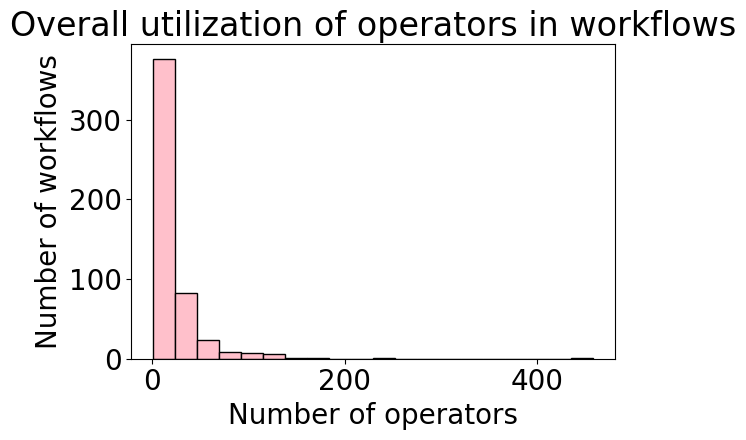

In [15]:
import matplotlib.pyplot as plt

# Plotting
plt.rc('font', size=20)
plt.hist(op_per_workflow.groupby('workflow')['operator'].sum(), bins=20, color='pink', edgecolor='black')
plt.title('Overall utilization of operators in workflows')
plt.xlabel('Number of operators')
plt.ylabel('Number of workflows')
plt.tight_layout()
plt.savefig('./plots/number_of_operators_workflows.png', format="png", bbox_inches='tight')
plt.show()

In [ ]:
import os
import re
import csv
import pandas as pd

def find_operators_in_processes(directory, pattern_list, output_file_name):
    result_list = []

    for pipeline in os.listdir(directory):
        subdirectory_path = os.path.join(directory, pipeline)
        folder_name = os.path.basename(subdirectory_path)

        for root, dirs, files in os.walk(subdirectory_path):
            for filename in files:
                file_path = os.path.join(root, filename)
                
                if filename.endswith('.nf') or filename.endswith('.config'):
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                        lines = file.readlines()
                    
                    process_flag = False
                    process_name = None
                    brace_stack = []

                    process_pattern = r'process\s+(\w+)\s*{'

                    for line_num, line in enumerate(lines):
                        stripped_line = line.strip()
                        
                        if line.strip().startswith('#') or line.strip().startswith('//') or line.strip().startswith('*'):
                                continue

                        if re.search(process_pattern, stripped_line):
                            process_flag = True
                            process_match = re.search(process_pattern, stripped_line)
                            if process_match:
                                process_name = process_match.group(1)
                            print(f'Process {process_name} in filepath {file_path}')
                            brace_stack.append('{')

                        if '{' in stripped_line:
                            brace_stack.append('{')

                        if '}' in stripped_line:
                            if brace_stack:
                                brace_stack.pop()
                                if not brace_stack and process_flag:
                                    process_flag = False

                        if process_flag:
                            pattern_found = False
                            for pattern in pattern_list:
                                regex_pattern = re.compile(r'\.' + re.escape(pattern) + r'(?!\w)' , re.IGNORECASE)
                                if regex_pattern.search(stripped_line):
                                    result_list.append([folder_name, process_name, pattern, file_path, line_num+1, stripped_line])
                                    print(f'Nextflow operator {pattern} with content: {stripped_line}')
                                    pattern_found = True
                                    break
                            if not pattern_found:
                                result_list.append([folder_name, process_name, 'none', file_path, 'none', 'none'])

                    if brace_stack:
                        print("Error: Unclosed process block in file:", file_path)

    with open(f'./results/{output_file_name}.csv', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['pipeline', 'process', 'operator', 'file_path', 'line_number', 'line_content'])
        writer.writerows(result_list)

In [8]:
import pandas as pd

df = pd.read_csv('./results/nextflow_operators_in_processes.csv')
#df = pd.read_csv('./results/all_operators_in_scripts_new.csv')

pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)

In [9]:
# drop duplica
df = df.drop_duplicates().reset_index()

In [10]:
df.head()

,index,pipeline,process_name,operator,file_path,line_number,line_content
0,0,airrflow,FASTQC_POSTASSEMBLY,none,./git_repos\airrflow\modules\local\fastqc_postassembly.nf,none,none
1,30,airrflow,FETCH_DATABASES,none,./git_repos\airrflow\modules\local\fetch_databases.nf,none,none
2,63,airrflow,GUNZIP,none,./git_repos\airrflow\modules\local\gunzip.nf,none,none
3,90,airrflow,MERGE_UMI,none,./git_repos\airrflow\modules\local\merge_UMI.nf,none,none
4,119,airrflow,PARSE_LOGS,none,./git_repos\airrflow\modules\local\parse_logs.nf,none,none


In [11]:
df['operator'].value_counts()

operator
none           3114
collect         610
join            357
set             123
map              86
mix              56
ifEmpty          40
filter           36
groupTuple       33
dump             33
flatten          31
toList           23
count            22
first            17
branch           13
collectFile      12
combine          12
concat           12
splitCsv         10
transpose         6
collate           6
unique            6
toInteger         6
max               5
merge             4
tap               4
buffer            3
subscribe         2
min               2
splitText         2
take              2
multiMap          2
view              1
flatMap           1
cross             1
last              1
Name: count, dtype: int64

In [12]:
operators_in_all_process = df.groupby(['pipeline', 'process_name']).size().reset_index(name='operator_count')
operators_in_all_process

,pipeline,process_name,operator_count
0,airrflow,ADD_META_TO_TAB,1
1,airrflow,AIRRFLOW_REPORT,1
2,airrflow,CHANGEO_ASSIGNGENES,1
3,airrflow,CHANGEO_CONVERTDB_FASTA,1
4,airrflow,CHANGEO_CREATEGERMLINES,1
...,...,...,...
3076,viralrecon,TABIX_BGZIP,1
3077,viralrecon,TABIX_TABIX,1
3078,viralrecon,UNICYCLER,1
3079,viralrecon,UNTAR,1


Processes without an operator get the entry 'none'

In [13]:
non_none_operator_rows = df[df['operator'] != 'none']
non_none_operator_rows

,index,pipeline,process_name,operator,file_path,line_number,line_content
14,427,airrflow,CHANGEO_MAKEDB,collect,./git_repos\airrflow\modules\local\changeo\changeo_makedb.nf,14,path(igblast) // igblast fasta from ch_igblast_db_for_process_igblast.mix(ch_igblast_db_for_process_igblast_mix).collect()
18,547,airrflow,COLLAPSE_DUPLICATES,join,./git_repos\airrflow\modules\local\enchantr\collapse_duplicates.nf,25,"echo ""${tabs.join('\n')}"" > tabs.txt"
20,590,airrflow,DEFINE_CLONES,join,./git_repos\airrflow\modules\local\enchantr\define_clones.nf,46,"def thr = threshold.join("""")"
21,595,airrflow,DEFINE_CLONES,join,./git_repos\airrflow\modules\local\enchantr\define_clones.nf,51,"input = tabs.join(',')"
23,641,airrflow,DETECT_CONTAMINATION,join,./git_repos\airrflow\modules\local\enchantr\detect_contamination.nf,26,"echo ""${tabs.join('\n')}"" > tabs.txt"
...,...,...,...,...,...,...,...
4661,141057,viralrecon,FASTQC,collect,./git_repos\viralrecon\modules\nf-core\fastqc\main.nf,25,"def old_new_pairs = reads instanceof Path || reads.size() == 1 ? [[ reads, ""${prefix}.${reads.extension}"" ]] : reads.withIndex().collect { entry, index -> [ entry, ""${prefix}_${index + 1}.${entry.extension}"" ] }"
4662,141058,viralrecon,FASTQC,join,./git_repos\viralrecon\modules\nf-core\fastqc\main.nf,26,def rename_to = old_new_pairs*.join(' ').join(' ')
4663,141059,viralrecon,FASTQC,collect,./git_repos\viralrecon\modules\nf-core\fastqc\main.nf,27,"def renamed_files = old_new_pairs.collect{ old_name, new_name -> new_name }.join(' ')"
4670,141344,viralrecon,MINIA,join,./git_repos\viralrecon\modules\nf-core\minia\main.nf,25,"def read_list = reads.join("","")"


In [14]:
operators_in_process = non_none_operator_rows.groupby(['pipeline', 'process_name']).size().reset_index(name='operator_count')
operators_in_process

,pipeline,process_name,operator_count
0,airrflow,CHANGEO_MAKEDB,1
1,airrflow,COLLAPSE_DUPLICATES,1
2,airrflow,DEFINE_CLONES,2
3,airrflow,DETECT_CONTAMINATION,1
4,airrflow,FASTQC,3
...,...,...,...
587,viralrecon,CAT_FASTQ,5
588,viralrecon,FASTQC,3
589,viralrecon,MINIA,1
590,viralrecon,PLOT_MOSDEPTH_REGIONS,1


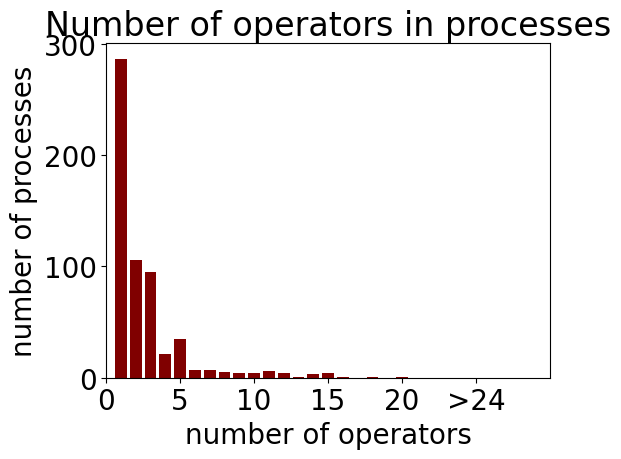

In [15]:
import matplotlib.pyplot as plt

counts = operators_in_process['operator_count'].value_counts().sort_index()
bins = counts.index

#bar_width = 0.5
plt.figure(figsize=(6, 5))

plt.rc('font', size=20)
plt.bar(bins, counts, color='maroon')
plt.xticks([0, 5, 10, 15, 20, 25], ["0", "5", "10", "15", "20", ">24"])
plt.xlim([0, 30]) 
plt.title('Number of operators in processes')
plt.xlabel('number of operators')
plt.ylabel('number of processes')
plt.tight_layout()
plt.savefig(f'./plots/operators_in_processes.png', format="png", bbox_inches='tight')
plt.show()